<a href="https://colab.research.google.com/github/LadyPary/GrapevineLeavesClassification/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_______
# **<center> Data Mining Course Project</center>**
## **<center> Grapevine Leaves Classification </center>**

#### <center>Zahra Rabbany Khorasgani</center> 
<center>610398124</center>

#### <center>Prof. Hedieh Sajedi</center>
#### <center>Department of Computer Science, Tehran University</center>

#### <center>July 2022</center>
_______



## **Importing**

In [ ]:
#Necessary packages

# for visualisation 
import matplotlib.pyplot as plt
plt.style.use('fast')
import seaborn as sns

# for math and dataframe
import numpy as np
import pandas as pd
from numpy import expand_dims

# for data mining
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold

# for deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50, MobileNetV2, MobileNet, NASNetMobile, DenseNet121, InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB3

from tensorflow.keras.applications.resnet50 import preprocess_input as preResNet50
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preMobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input as preMobileNet
from tensorflow.keras.applications.nasnet import preprocess_input as preNASNetMobile
from tensorflow.keras.applications.densenet import preprocess_input as preDenseNet121
from tensorflow.keras.applications.inception_v3 import preprocess_input as preInceptionV3
from tensorflow.keras.applications.efficientnet import preprocess_input as preEfficientNetB3

from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from keras.layers import GaussianNoise
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
#!pip install scikeras
from scikeras.wrappers import KerasClassifier

# utilities
from PIL import Image
from tqdm import tqdm
import random as rnd
import cv2
#!pip install livelossplot
from livelossplot import PlotLossesKeras
import inspect
from tqdm import tqdm

%matplotlib inline

# **Grapevine Leaves Classification**

**Attribute Information:**

*   This dataset is a collection of png pictures of five class of grapevine leaves. Namely **Ak**, **Ala Idris**, **Nazli**, **Buzgulu**, and **Dimnit**.

## **1. Loading The Dataset and Preprocessing**

### **1.1. Loading**

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
#drive.mount('/gdrive', force_remount=True)

# Location of Zip File
drive_path = '/gdrive/MyDrive/Copy of Grapevine_Leaves_Image_Dataset.zip'
local_path = '/content'

# Copy the zip file and move it up one level (AKA out of the drive folder)
!cp '{drive_path}' .

# Navigate to the copied file and unzip it quietly
os.chdir(local_path)
!unzip -q 'Copy of Grapevine_Leaves_Image_Dataset.zip'

replace __MACOSX/._Grapevine_Leaves_Image_Dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
path = '/content/Grapevine_Leaves_Image_Dataset/'

df = pd.DataFrame()
label,paths = [], []

df['images'] = os.listdir(path+'Ak') + os.listdir(path+'Ala_Idris') + \
               os.listdir(path+'Buzgulu') + os.listdir(path+'Dimnit') + \
               os.listdir(path+'Nazli')

for image in df['images']:
    classN = image.split(' (')[0]
    label.append(classN)
    paths.append(path+classN+'/'+image)
    
df['label'] = label
df['path'] = paths

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  500 non-null    object
 1   label   500 non-null    object
 2   path    500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


In [ ]:
df.head()

,images,label,path
0,Ak (51).png,Ak,/content/Grapevine_Leaves_Image_Dataset/Ak/Ak ...
1,Ak (21).png,Ak,/content/Grapevine_Leaves_Image_Dataset/Ak/Ak ...
2,Ak (4).png,Ak,/content/Grapevine_Leaves_Image_Dataset/Ak/Ak ...
3,Ak (10).png,Ak,/content/Grapevine_Leaves_Image_Dataset/Ak/Ak ...
4,Ak (69).png,Ak,/content/Grapevine_Leaves_Image_Dataset/Ak/Ak ...


In [ ]:
print('Number of Leaves Classes: ',len(df['label'].value_counts()))
print("---------------------")
print("Number of Leaves in Each Class:")
print(df['label'].value_counts())
print("---------------------")

Number of Leaves Classes:  5
---------------------
Number of Leaves in Each Class:
Ak           100
Ala_Idris    100
Buzgulu      100
Dimnit       100
Nazli        100
Name: label, dtype: int64
---------------------


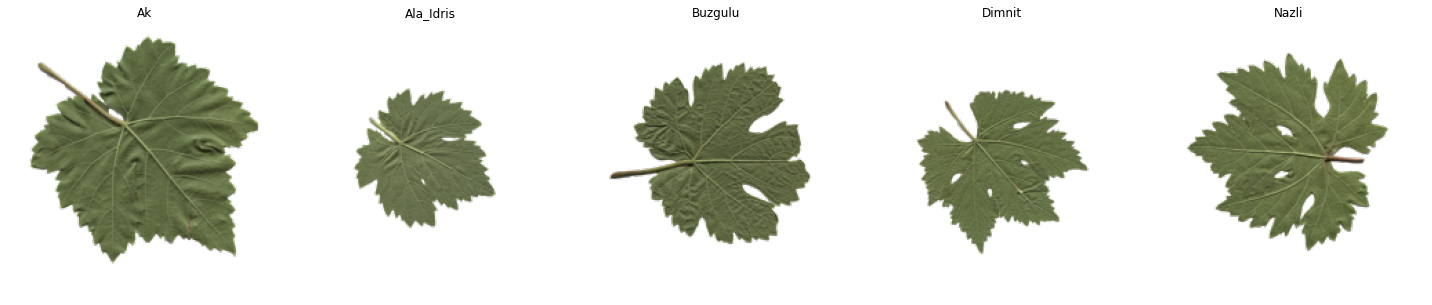

In [ ]:
plt.figure(figsize = (20,12))
for idx,i in enumerate(df.label.unique()):
    plt.subplot(1,5,idx+1)
    plt.title(i)
    plt.axis('off')

    df1 = df[df['label'] ==i].reset_index(drop = True)
    img_path = df1.loc[rnd.randint(0, len(df1))-1,'path']
    plt.imshow(Image.open(img_path).resize((200,200)))

plt.tight_layout()
plt.show()

### **1.2. Splitting Train/Test/Validation Data**


In [ ]:
# Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(df[['path', 'label']], df[['label']], test_size=0.2, random_state=42, shuffle=True)
# Train and Validation Split -> note that we only augment the training and validation sets.
#                               since we are augmentaiting the dataset on the fly when building
#                               the model, we should do the seperation before hand. 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
batch_size=32

# Number of training examples and labels
num_train = X_train.shape[0]
num_validation = X_val.shape[0]
num_test = X_test.shape[0]
num_classes = 5
num_iterations = int(num_train/batch_size)

# Print important info
print(f'Num train images: {num_train} \
        \nNum validation images: {num_validation} \
        \nNum test images: {num_test} \
        \nNum classes: {num_classes} \
        \nNum iterations per epoch: {num_iterations}')

Num train images: 320         
Num validation images: 80         
Num test images: 100         
Num classes: 5         
Num iterations per epoch: 10


### **1.3. Data Augmentation**

**Using image data augmentation**

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.


train, test, and validation generators

In [ ]:
train_val_generator = ImageDataGenerator(
    rotation_range=45,
    zoom_range=[0.8, 1.2], # 80% to 120%
    brightness_range=[0.5,1.5],
    channel_shift_range=0.5,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0.0)

#test_val_generator_=ImageDataGenerator(rescale=1/255.0)
test_val_generator_=ImageDataGenerator()

In [ ]:
# Augmentation

# Important note: preprocess function also rescales for your target model 
# so don't rescale if you are using a preprocess function!

# reading images using flow_from_directory

# Train and validation data augmentation
def augment_train_val_data(source_df, input_shape, preprocess):
  train_val_generator = ImageDataGenerator(
      rotation_range=45,
      zoom_range=[0.8, 1.2], # 80% to 120%
      brightness_range=[0.5,1.5],
      channel_shift_range=0.5,
      width_shift_range=0.15,
      height_shift_range=0.15,
      shear_range=0.15,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='constant',
      cval=0.0,
      preprocessing_function= preprocess,
      #rescale=1/255.0
      #validation_split=0.2
      )
  
  return train_val_generator.flow_from_dataframe(
          source_df,  # This is the source dataframe for training images
          x_col='path',
          y_col='label',
          target_size= input_shape,  # All images will be resized to this size
          batch_size=32,
          class_mode="categorical",
          shuffle=True)

def test_val_generator(source_df, input_shape, preprocess):
  test_val_generator=ImageDataGenerator(preprocessing_function= preprocess)

  # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
  # this insures that we go through all the sample in the test set exactly once.
  length=len(source_df)
  batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
  steps=int(length/batch_size)
  msg='{0:70s} for generator'.format(' ')
  print(msg, '\r', end='') 
  gen = test_val_generator.flow_from_dataframe(source_df, x_col='path', y_col='label', target_size=input_shape,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
  return gen 

In [ ]:
# function below takes a data generator and plots some random images
# followed by them being augmented!
def showAugmentedData(paths, datagen):
    
    plt.figure(figsize = (10,10))
    plt.suptitle('Augmented Images')
    
    midx = 0
    for path in paths:
        orgImg = Image.open(path).resize((200,200))
        it = datagen.flow(expand_dims(orgImg, 0), batch_size=1)
    
        # Original Image
        plt.subplot(5,5, midx+1)
        plt.imshow(orgImg)
        plt.axis('off')
    
        # Augmented Images
        for idx, i in enumerate(range(4)):
            midx += 1
            plt.subplot(5,5, midx+1)
            plt.imshow(it.next()[0].astype('uint8'))
            plt.axis('off')
        midx += 1
    
    plt.tight_layout()
    plt.show()

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.


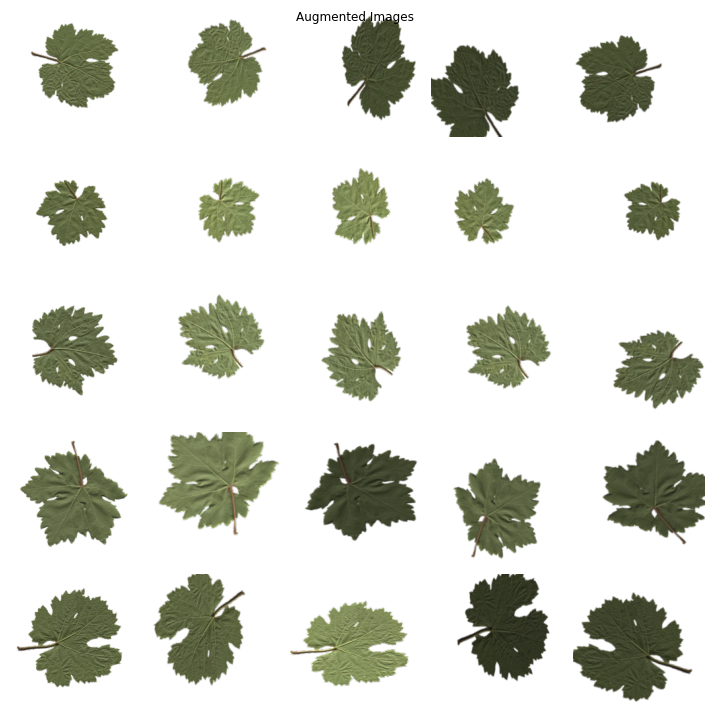

In [ ]:
preprocess = preMobileNet
input_shape = (227, 227, 3)

train_generator= augment_train_val_data(X_train, input_shape, preprocess)
validate_generator= augment_train_val_data(X_val, input_shape, preprocess)
  
showAugmentedData(np.random.choice(X_train['path'],5),train_val_generator)

## **2. Training The Model**

### **2.1. Pre-trained Convolutional Neural Network (Transfer Learning)**

In [ ]:
# List all available pre_trained models in Keras
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}

In [ ]:
for key in model_dictionary.keys():
  print(key)

DenseNet121
DenseNet169
DenseNet201
EfficientNetB0
EfficientNetB1
EfficientNetB2
EfficientNetB3
EfficientNetB4
EfficientNetB5
EfficientNetB6
EfficientNetB7
EfficientNetV2B0
EfficientNetV2B1
EfficientNetV2B2
EfficientNetV2B3
EfficientNetV2L
EfficientNetV2M
EfficientNetV2S
InceptionResNetV2
InceptionV3
MobileNet
MobileNetV2
MobileNetV3Large
MobileNetV3Small
NASNetLarge
NASNetMobile
ResNet101
ResNet101V2
ResNet152
ResNet152V2
ResNet50
ResNet50V2
VGG16
VGG19
Xception


Due to hardware limitations I cannot try all the possible pre_trained models. Therefore I'll try the top 5 models with maximum accuracy and minimum number of params using the image below as refrence. 
Image taken from [this notebook](https://colab.research.google.com/drive/1bi0XpDOZE8N3n78op6ykHSkfJ_0vd1oE#scrollTo=V84Ghlke7jGr).

Chosen models are:
1. MobileNetV2
2. MobileNet
3. NASNetMobile
4. DenseNet121
5. InceptionV3

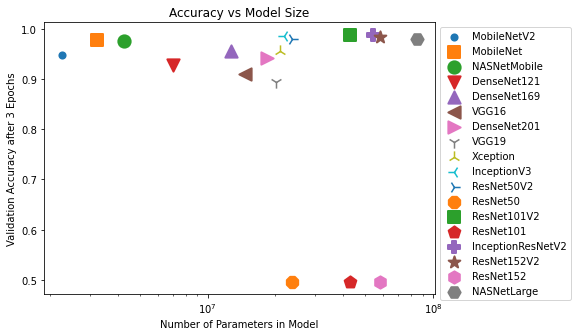

In [ ]:
model_comparison = {'Model_Name': [], #'MobileNetV2','MobileNet','NASNetMobile','DenseNet121','InceptionV3'
                    'Num_Model_Params': [],
                    'Validation_Accuracy': [],
                    'Test_Accuracy':[],
                    'Optimizer_Algo': [], 
                    'Learning_Rate':[],
                    'Momentum':[],
                    'Epoch':[],
                    'Pooling':[], 
                    'Num_preTrainable_Layers':[], 
                    'Activation':[]
                    }

In [ ]:
def TrainTransfer(model_name,
                  optimizer_algo='adam', learning_rate=0.001, momentum=0.9,
                  epoch=10, pooling='avg', 
                  no_trainable_layers=3, 
                  activation='softmax'):
  '''
  Parameters: 
        model_name (string):  DenseNet(121, 169, 201), 
                              EfficientNet(B0, B1, B2, B3, B4, B5, B6, B7, V2B0, V2B1, V2B2, V2B3, V2L, V2M, V2S),
                              InceptionResNetV2, InceptionV3,
                              MobileNet, MobileNetV2, MobileNetV3Large, MobileNetV3Small
                              NASNetLarge, NASNetMobile,
                              ResNet(101, 101V2, 152, 152V2, 50, 50V2),
                              VGG16, VGG19,
                              Xception

        optimizer_algo (string): SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax,Nadam, Ftrl
        learning_rate (float): 0.001
        momentum (float): 0.9
        epoch (int): 10
        pooling (string): 'max', 'min', 'avg'
        no_trainable_layers (int): number of last layers to unfreeze
        activation (string): 'relu', 'softmax', 'sigmoid', 'softplus',
                            'softsign', 'tanh', 'selu', 'elu', 'exponential' 
  Outputs: new_model, history

  '''
  model = model_dictionary[model_name]

  # Handeling the image shapes
  # Special handling for "NASNetLarge" since it requires input images with size (331,331)
  if model_name=='NASNetLarge':
      input_shape=(331,331)
  else:
      input_shape=(224,224)

  # load the pre-trained model with pooling as the last layer and freeze the model weights
  pre_trained_model = model(include_top=False, pooling=pooling, input_shape=(input_shape[0], input_shape[1], 3), weights = 'imagenet')

  # freeze or unfreeze the trainable layers
  for layer in pre_trained_model.layers[0:len(pre_trained_model.layers)-no_trainable_layers]:
    layer.trainable=False

  '''
  x = pre_trained_model.output
  #x = layers.GlobalAveragePooling2D()(x)
  x = layers.Flatten()(x)
  x = layers.Dense(units=512, activation='relu')(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(units=512, activation='relu')(x)
  x = layers.Dropout(0.3)(x)
  output  = layers.Dense(units=5, activation='softmax')(x)
  model = Model(pre_trained_model.input, output)
  
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(
          optimizer=optimizer,
          loss="categorical_crossentropy",
          metrics=["accuracy"])
  '''

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.

  # custom modifications on top of pre-trained model
  model = keras.models.Sequential()

  # Create new model on top
  model.add(keras.Input(shape=(input_shape[0], input_shape[1], 3)))
  model.add(pre_trained_model)
  #model.add(keras.layers.GlobalAveragePooling2D())
  model.add(layers.Dense(units=512, activation='relu'))
  model.add(keras.layers.Dropout(0.2))  # Regularize with dropout
  model.add(layers.Dense(units=512, activation='relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(units=5, activation='softmax'))

  # units: dimensionality of the output space.
  #model.add(keras.layers.Dense(units=5, activation=activation))

  # optimizer algorithm 
  #opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

  # complie the model
  model.compile(loss='categorical_crossentropy', optimizer=optimizer_algo, metrics=['accuracy'])
 

  # Calculate all relevant metrics
  model_comparison['Model_Name'].append(model_name)
  model_comparison['Num_Model_Params'].append(pre_trained_model.count_params())
  model_comparison['Optimizer_Algo'].append(optimizer_algo)
  model_comparison['Learning_Rate'].append(learning_rate)
  model_comparison['Momentum'].append(momentum)
  model_comparison['Epoch'].append(epoch)
  model_comparison['Pooling'].append(pooling)
  model_comparison['Activation'].append(activation)
  model_comparison['Num_preTrainable_Layers'].append(no_trainable_layers)

  return model

In [ ]:
def FitTransfer(X, model, model_name, epoch=10):
  '''
  Parameters: X and of train, 
              model: output of TrainTransfer 
              epoch
  Outputs: history
  '''
  # Handeling the image shapes
  # Special handling for "NASNetLarge" since it requires input images with size (331,331)
  if model_name=='NASNetLarge':
      input_shape=(331,331)
  else:
      input_shape=(224,224)

  # simple early stopping
  es = EarlyStopping(monitor='val_loss',min_delta=0, mode='auto', verbose=2, 
                     patience=10, baseline=None, restore_best_weights=True)

  # setting the preprocess 
  if model_name== "EfficientNetB3":
      preprocessName = preEfficientNetB3
  elif model_name == 'MobileNetV2':
    preprocessName = preMobileNetV2
  elif model_name == 'ResNet50':
    preprocessName = preResNet50
  elif model_name == 'InceptionV3':
    preprocessName = preInceptionV3

  # fitting the model 
  history = model.fit(augment_train_val_data(X_train, input_shape, preprocessName),
                      validation_data=augment_train_val_data(X_val, input_shape, preprocessName),
                      steps_per_epoch=num_iterations, 
                      epochs=epoch, 
                      verbose=1, 
                      callbacks=[es])
  best_acc = max(history.history['val_accuracy'])*100
  model_comparison['Validation_Accuracy'].append(best_acc)
  print("-------------------")
  print("Best accuracy achieved:", round(best_acc, 4), "%")
  return history

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()

In [ ]:
classes=list(train_generator.class_indices.keys())
class_indices=list(train_generator.class_indices.values())
class_count=len(classes)
labels=test_val_generator(X_test, input_shape, preprocess).labels
length=len(X_test)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 100 validated image filenames belonging to 5 classes.
test batch size:  50   test steps:  3  number of classes :  5


In [ ]:
def predictor(generator, steps, model):
    y_pred= []
    y_true=generator.labels

    classes=list(train_generator.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(generator,verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
            pred_index=np.argmax(p)         
            true_index=generator.labels[i]  # labels are integer values
            if pred_index != true_index:    # a misclassification has occurred                                           
                errors=errors + 1
            y_pred.append(pred_index)
    acc=(1-errors/tests)*100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    model_comparison["Test_Accuracy"].append(acc)
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)

    cm = confusion_matrix(ytrue,ypred)
    
    # plot the confusion matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
    plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests

#### MobileNetV2

In [ ]:
model_name = 'MobileNetV2'
epoch = 150
new_model= TrainTransfer(model_name, epoch=epoch, optimizer_algo='adam', activation='softmax', no_trainable_layers=0, pooling='avg')
history = FitTransfer(X_train, new_model, model_name, epoch)

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/150
10/10 [==============================] - 10s 815ms/step - loss: 1.9982 - accuracy: 0.2594 - val_loss: 1.4180 - val_accuracy: 0.4875
Epoch 2/150
10/10 [==============================] - 7s 668ms/step - loss: 1.3729 - accuracy: 0.4313 - val_loss: 1.0789 - val_accuracy: 0.5875
Epoch 3/150
10/10 [==============================] - 7s 666ms/step - loss: 1.1955 - accuracy: 0.5250 - val_loss: 0.9849 - val_accuracy: 0.6500
Epoch 4/150
10/10 [==============================] - 7s 660ms/step - loss: 1.0652 - accuracy: 0.5875 - val_loss: 1.0220 - val_accuracy: 0.4875
Epoch 5/150
10/10 [==============================] - 7s 674ms/step - loss: 0.9773 - accuracy: 0.6406 - val_loss: 0.9063 - val_accuracy: 0.6000
Epoch 6/150
10/10 [==============================] - 7s 673ms/step - loss: 0.8768 - accuracy: 0.6438 - val_loss: 0.8574 - val_accuracy: 0.6500
Epoch 7/150
10/10 [===

In [ ]:
new_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_3 (Dense)             (None, 512)               655872    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 2565      
                                                      

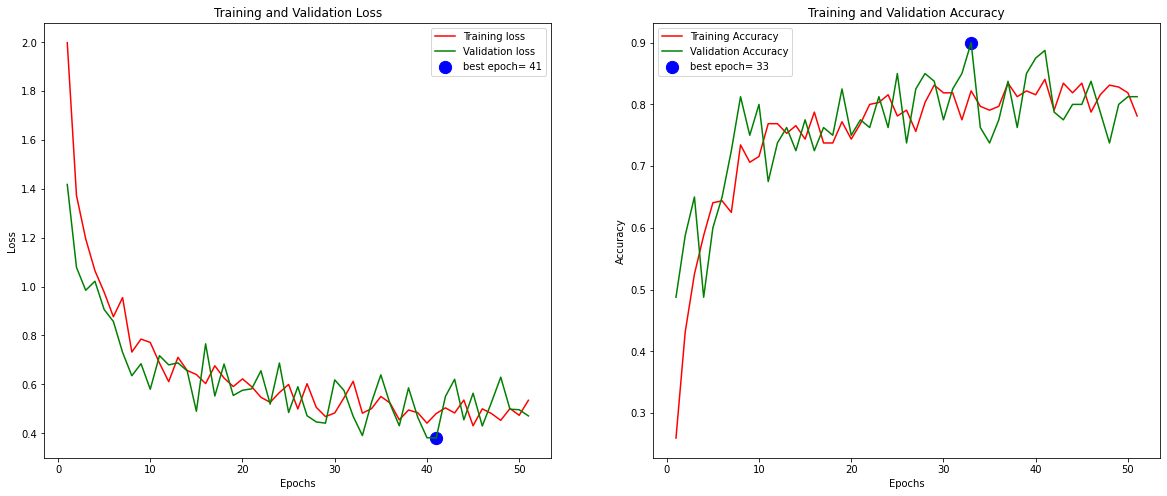

In [ ]:
tr_plot(history,0)

Found 100 validated image filenames belonging to 5 classes.
2/2 [==============================] - 1s 272ms/step
there were 20 errors in 100 tests for an accuracy of  80.00


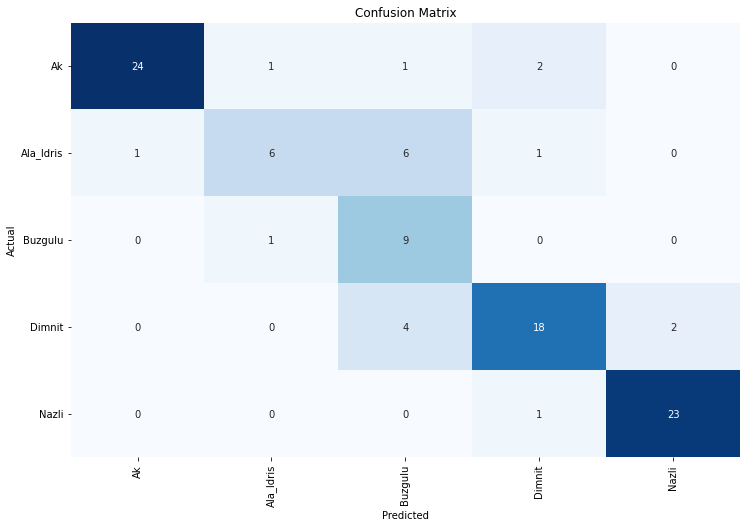

Classification Report:
----------------------
               precision    recall  f1-score   support

          Ak     0.9600    0.8571    0.9057        28
   Ala_Idris     0.7500    0.4286    0.5455        14
     Buzgulu     0.4500    0.9000    0.6000        10
      Dimnit     0.8182    0.7500    0.7826        24
       Nazli     0.9200    0.9583    0.9388        24

    accuracy                         0.8000       100
   macro avg     0.7796    0.7788    0.7545       100
weighted avg     0.8360    0.8000    0.8031       100



In [ ]:
errors, tests=predictor(test_val_generator(X_test, (224, 224), preprocess), test_steps, new_model)

#### ResNet50

In [ ]:
model_name = 'ResNet50'
epoch = 150
preprocess = preResNet50
no_trainable_layers = 2

resnet50 = ResNet50(include_top = False, pooling= 'avg',input_shape = (227,227,3), weights = 'imagenet')


for layer in resnet50.layers[0:len(resnet50.layers)-no_trainable_layers]:
    layer.trainable=False

#resnet50_output= layers.GlobalAveragePooling2D()(resnet50.output)
resnet50_output= layers.Dense(128, activation = 'relu')(resnet50.output)
resnet50_output= layers.Dense(5, activation = 'softmax')(resnet50.output)
model_resnet50 = Model(inputs = resnet50.input, outputs = resnet50_output)
model_resnet50.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])


# simple early stopping
es = EarlyStopping(monitor='val_loss',min_delta=0, mode='auto', verbose=2, 
                    patience=10, baseline=None, restore_best_weights=True)
  
input_shape = (227,227)
history_resnet50 = model_resnet50.fit(
      augment_train_val_data(X_train, input_shape, preprocess),
      validation_data=augment_train_val_data(X_val, input_shape, preprocess),
      epochs=50,
      verbose=2,
      callbacks=[es])

best_acc = max(history_resnet50.history['val_accuracy'])*100
print("-------------------")
print("Best accuracy achieved:", round(best_acc, 4), "%")

#new_model= TrainTransfer(model_name, epoch=epoch, optimizer_algo='adam', activation='softmax', no_trainable_layers=5, pooling='avg')
#history = FitTransfer(X_train, new_model, model_name, epoch)

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/50
10/10 - 12s - loss: 1.9149 - accuracy: 0.2094 - val_loss: 1.7229 - val_accuracy: 0.2125 - 12s/epoch - 1s/step
Epoch 2/50
10/10 - 7s - loss: 1.6737 - accuracy: 0.2594 - val_loss: 1.6481 - val_accuracy: 0.2125 - 7s/epoch - 709ms/step
Epoch 3/50
10/10 - 7s - loss: 1.5706 - accuracy: 0.2969 - val_loss: 1.4490 - val_accuracy: 0.4125 - 7s/epoch - 708ms/step
Epoch 4/50
10/10 - 7s - loss: 1.4512 - accuracy: 0.3875 - val_loss: 1.3535 - val_accuracy: 0.4250 - 7s/epoch - 715ms/step
Epoch 5/50
10/10 - 8s - loss: 1.3794 - accuracy: 0.4062 - val_loss: 1.3627 - val_accuracy: 0.5000 - 8s/epoch - 776ms/step
Epoch 6/50
10/10 - 7s - loss: 1.3106 - accuracy: 0.4938 - val_loss: 1.2607 - val_accuracy: 0.4625 - 7s/epoch - 708ms/step
Epoch 7/50
10/10 - 7s - loss: 1.2480 - accuracy: 0.5500 - val_loss: 1.2122 - val_accuracy: 0.4875 - 7s/epoch - 710ms/step
Epoch 8/50
10/10 - 7s - loss

In [ ]:
model_resnet50.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 233, 233, 3)  0           ['input_37[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 114, 114, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

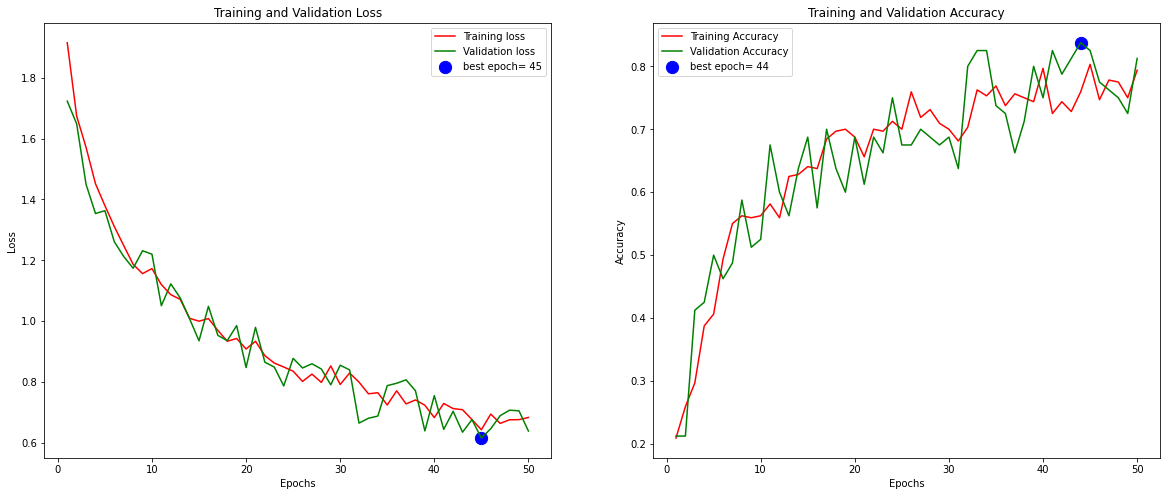

In [ ]:
tr_plot(history_resnet50,0)

Found 100 validated image filenames belonging to 5 classes.
2/2 [==============================] - 1s 295ms/step
there were 52 errors in 100 tests for an accuracy of  48.00


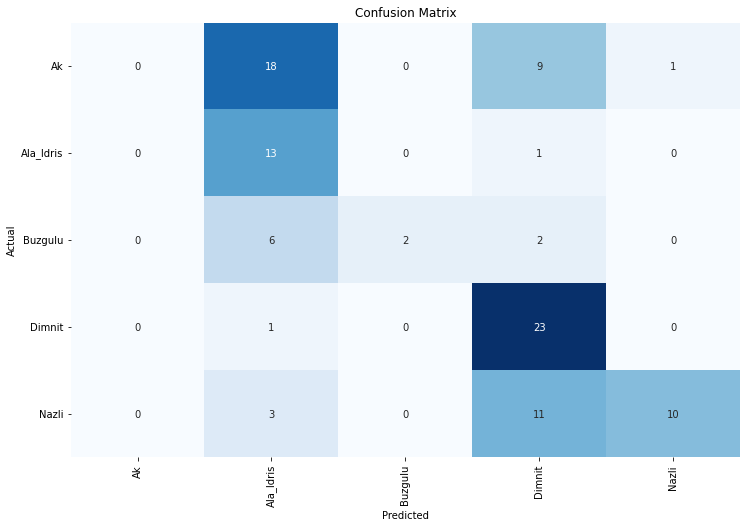

Classification Report:
----------------------
               precision    recall  f1-score   support

          Ak     0.0000    0.0000    0.0000        28
   Ala_Idris     0.3171    0.9286    0.4727        14
     Buzgulu     1.0000    0.2000    0.3333        10
      Dimnit     0.5000    0.9583    0.6571        24
       Nazli     0.9091    0.4167    0.5714        24

    accuracy                         0.4800       100
   macro avg     0.5452    0.5007    0.4069       100
weighted avg     0.4826    0.4800    0.3944       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
errors, tests=predictor(test_val_generator(X_test, (224, 224), preprocess), test_steps, model_resnet50)

#### EfficientNetB3

In [ ]:
model_name = 'EfficientNetB3'
epoch = 150
preprocess = preEfficientNetB3
no_trainable_layers = 10

efficientNetB3 = EfficientNetB3(include_top = False, pooling= 'max',input_shape = (227,227,3), weights = 'imagenet')


for layer in efficientNetB3.layers[0:len(efficientNetB3.layers)-no_trainable_layers]:
    layer.trainable=False

'''
model_efficientNetB3 = keras.models.Sequential()

# Create new model on top
model_efficientNetB3.add(keras.Input(shape=(input_shape[0], input_shape[1], 3)))
model_efficientNetB3.add(efficientNetB3)
#model_efficientNetB3.add(keras.layers.GlobalAveragePooling2D())
#model_efficientNetB3.add(layers.Dense(units=512, activation='relu'))
#model_efficientNetB3.add(keras.layers.Dropout(0.2))  # Regularize with dropout
model_efficientNetB3.add(layers.Dense(units=512, activation='relu'))
model_efficientNetB3.add(layers.Dropout(0.3))
model_efficientNetB3.add(layers.Dense(units=5, activation='softmax'))

model_efficientNetB3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
'''

x= efficientNetB3.output
x= keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x= Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=layers.Dropout(rate=.45, seed=123)(x)        
output=Dense(5, activation='softmax')(x)
model_efficientNetB3=Model(inputs=efficientNetB3.input, outputs=output)
model_efficientNetB3.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) 


# simple early stopping
es = EarlyStopping(monitor='val_loss',min_delta=0, mode='auto', verbose=2, 
                    patience=10, baseline=None, restore_best_weights=True)

input_shape = (227,227)
history_efficientNetB3 = model_efficientNetB3.fit(
      augment_train_val_data(X_train, input_shape, preprocess),
      validation_data=augment_train_val_data(X_val, input_shape, preprocess),
      epochs=epoch,
      verbose=2,
      callbacks=[es])

best_acc = max(history_efficientNetB3.history['val_accuracy'])*100
print("-------------------")
print("Best accuracy achieved:", round(best_acc, 4), "%")

#new_model= TrainTransfer(model_name, epoch=epoch, optimizer_algo='adam', activation='softmax', no_trainable_layers=5, pooling='avg')
#history = FitTransfer(X_train, new_model, model_name, epoch)

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/150
10/10 - 21s - loss: 10.0966 - accuracy: 0.3063 - val_loss: 14.8319 - val_accuracy: 0.4000 - 21s/epoch - 2s/step
Epoch 2/150
10/10 - 7s - loss: 9.3637 - accuracy: 0.4781 - val_loss: 14.8736 - val_accuracy: 0.2500 - 7s/epoch - 697ms/step
Epoch 3/150
10/10 - 7s - loss: 8.8826 - accuracy: 0.5094 - val_loss: 11.8457 - val_accuracy: 0.4750 - 7s/epoch - 711ms/step
Epoch 4/150
10/10 - 7s - loss: 8.7018 - accuracy: 0.4938 - val_loss: 11.3007 - val_accuracy: 0.3875 - 7s/epoch - 718ms/step
Epoch 5/150
10/10 - 7s - loss: 8.1885 - accuracy: 0.6250 - val_loss: 10.0045 - val_accuracy: 0.4500 - 7s/epoch - 713ms/step
Epoch 6/150
10/10 - 7s - loss: 7.8933 - accuracy: 0.6062 - val_loss: 9.5592 - val_accuracy: 0.5375 - 7s/epoch - 715ms/step
Epoch 7/150
10/10 - 7s - loss: 7.7864 - accuracy: 0.6313 - val_loss: 9.2514 - val_accuracy: 0.5000 - 7s/epoch - 720ms/step
Epoch 8/150
10/

In [ ]:
model_efficientNetB3.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_52 (InputLayer)          [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_9 (Rescaling)        (None, 227, 227, 3)  0           ['input_52[0][0]']               
                                                                                                  
 normalization_9 (Normalization  (None, 227, 227, 3)  7          ['rescaling_9[0][0]']            
 )                                                                                                
                                                                                            

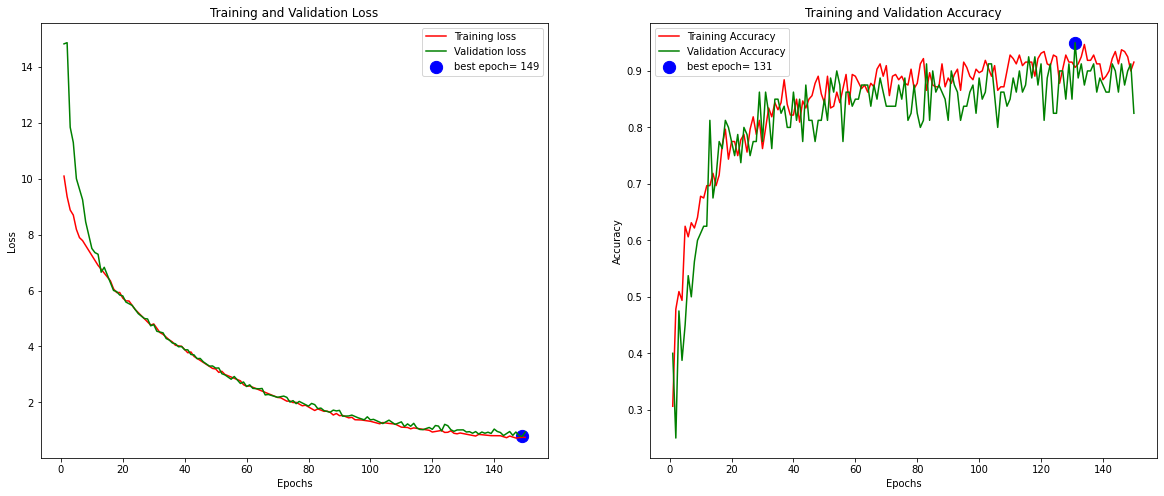

In [ ]:
tr_plot(history_efficientNetB3,0)

Found 100 validated image filenames belonging to 5 classes.
2/2 [==============================] - 1s 308ms/step
there were 11 errors in 100 tests for an accuracy of  89.00


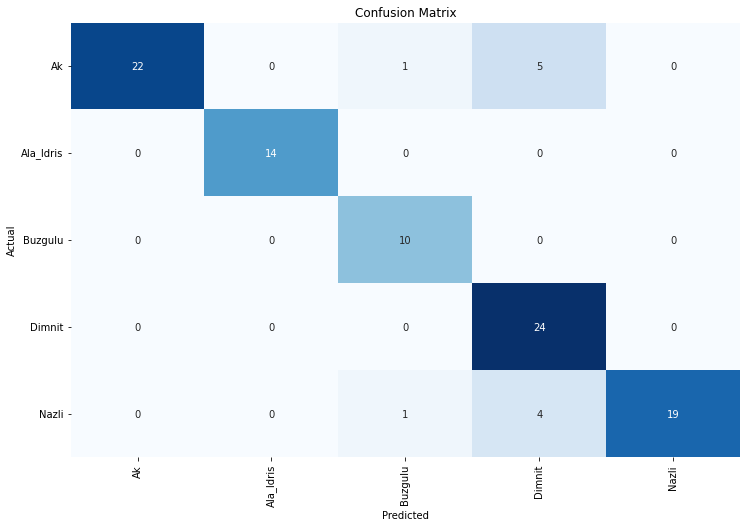

Classification Report:
----------------------
               precision    recall  f1-score   support

          Ak     1.0000    0.7857    0.8800        28
   Ala_Idris     1.0000    1.0000    1.0000        14
     Buzgulu     0.8333    1.0000    0.9091        10
      Dimnit     0.7273    1.0000    0.8421        24
       Nazli     1.0000    0.7917    0.8837        24

    accuracy                         0.8900       100
   macro avg     0.9121    0.9155    0.9030       100
weighted avg     0.9179    0.8900    0.8915       100



In [ ]:
errors, tests=predictor(test_val_generator(X_test, (227, 227), preprocess), test_steps, model_efficientNetB3)

#### InceptionV3

In [ ]:
model_name = 'InceptionV3'
epoch = 150
preprocess = preInceptionV3
no_trainable_layers = 15

inceptionV3 = InceptionV3(include_top = False, pooling= 'max',input_shape = (227,227,3), weights = 'imagenet')


for layer in inceptionV3.layers[0:len(inceptionV3.layers)-no_trainable_layers]:
    layer.trainable=False

'''
x = inceptionV3.output
#x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(units=512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(units=512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output  = layers.Dense(units=5, activation='softmax')(x)
model_inceptionV3 = Model(inceptionV3.input, output)

optimizer = Adam(learning_rate=0.001)
model_inceptionV3.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"])

'''

model_inceptionV3 = keras.models.Sequential([
        inceptionV3,
        layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 ),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                     bias_regularizer=regularizers.l1(0.006) ,activation='relu'),
        layers.Dropout(rate=.45, seed=123),
        layers.Dense(5, activation='softmax')
    ])

model_inceptionV3.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) 


'''
x= inceptionV3.output
x= keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x= Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=layers.Dropout(rate=.45, seed=123)(x)        
output=Dense(5, activation='softmax')(x)
model_inceptionV3=Model(inputs=inceptionV3.input, outputs=output)
model_inceptionV3.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) 
'''

# simple early stopping
es = EarlyStopping(monitor='val_loss',min_delta=0, mode='auto', verbose=2, 
                    patience=30, baseline=None, restore_best_weights=True)

input_shape = (227,227)
history_inceptionV3 = model_inceptionV3.fit(
      augment_train_val_data(X_train, input_shape, preprocess),
      validation_data=augment_train_val_data(X_val, input_shape, preprocess),
      epochs=epoch,
      verbose=2,
      callbacks=[es])

best_acc = max(history_inceptionV3.history['val_accuracy'])*100
print("-------------------")
print("Best accuracy achieved:", round(best_acc, 4), "%")

#new_model= TrainTransfer(model_name, epoch=epoch, optimizer_algo='adam', activation='softmax', no_trainable_layers=5, pooling='avg')
#history = FitTransfer(X_train, new_model, model_name, epoch)

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
model_inceptionV3.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 batch_normalization_1699 (B  (None, 2048)             8192      
 atchNormalization)                                              
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_45 (Dropout)        (None, 2048)              0         
                                                                 
 dense_73 (Dense)            (None, 128)               262272    
                                                                 
 dropout_46 (Dropout)        (None, 128)               0         
                                                     

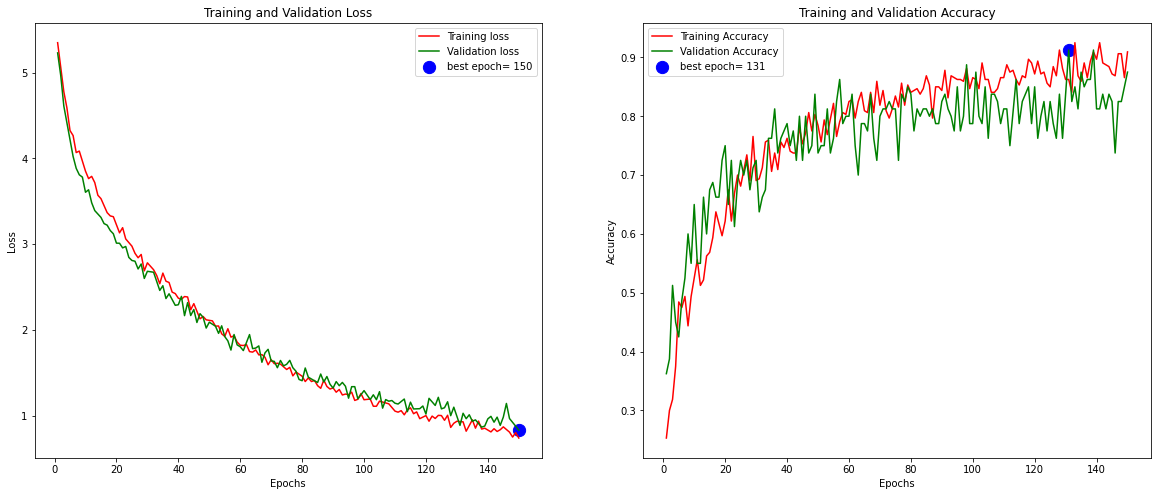

In [ ]:
tr_plot(history_inceptionV3,0)

Found 100 validated image filenames belonging to 5 classes.
2/2 [==============================] - 1s 306ms/step
there were 12 errors in 100 tests for an accuracy of  88.00


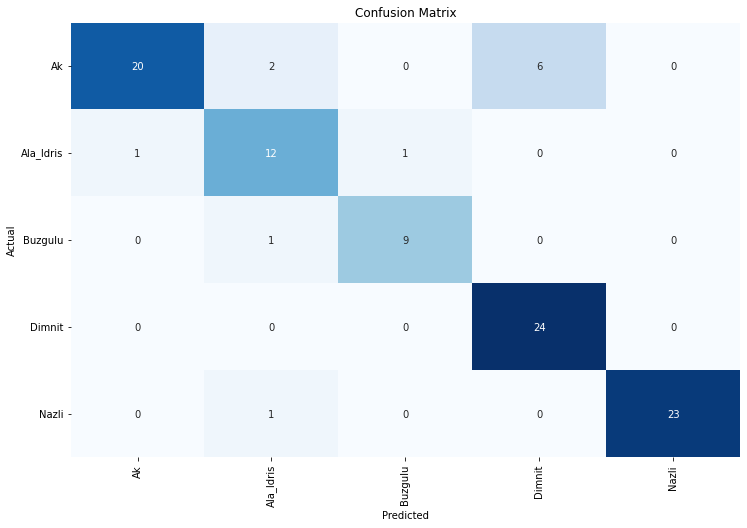

Classification Report:
----------------------
               precision    recall  f1-score   support

          Ak     0.9524    0.7143    0.8163        28
   Ala_Idris     0.7500    0.8571    0.8000        14
     Buzgulu     0.9000    0.9000    0.9000        10
      Dimnit     0.8000    1.0000    0.8889        24
       Nazli     1.0000    0.9583    0.9787        24

    accuracy                         0.8800       100
   macro avg     0.8805    0.8860    0.8768       100
weighted avg     0.8937    0.8800    0.8788       100



In [ ]:
errors, tests=predictor(test_val_generator(X_test, (227, 227), preprocess), test_steps, model_inceptionV3)

Summery of best of above

In [ ]:
model_comparison = {'Model_Name': ['MobileNetV2', 'ResNet50', 'EfficientNetB3', 'InceptionV3'],
                    'Num_Trainable_Params': [921093, 2369029, 2099717, 695173],
                    'Validation_Accuracy': [90, 81, 96, 91],
                    'Test_Accuracy':[80, 75, 89, 88]}

In [ ]:
# Convert Results to DataFrame for easy viewing
model_comparison_df = pd.DataFrame(model_comparison)
model_comparison_df.sort_values('Test_Accuracy', inplace=True, ascending=False) # sort in ascending order of num_model_params column
model_comparison_df

,Model_Name,Num_Trainable_Params,Validation_Accuracy,Test_Accuracy
2,EfficientNetB3,2099717,96,89
3,InceptionV3,695173,91,88
0,MobileNetV2,921093,90,80
1,ResNet50,2369029,81,75


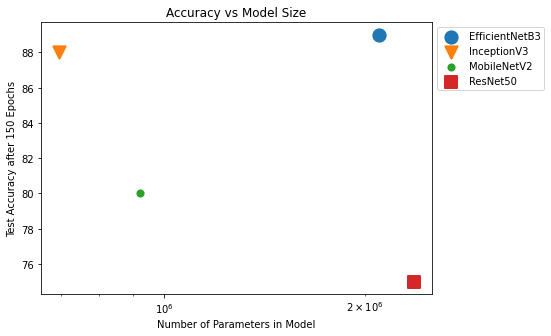

In [ ]:
# Loop over each row and plot the num_model_params vs validation_accuracy
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]
plt.figure(figsize=(7,5))
for row in model_comparison_df.itertuples():
    plt.scatter(row.Num_Trainable_Params, row.Test_Accuracy, label=row.Model_Name, marker=markers[row.Index], s=150, linewidths=2)
plt.xscale('log')
plt.xlabel('Number of Parameters in Model')
plt.ylabel('Test Accuracy after {} Epochs'.format(epoch))
plt.title('Accuracy vs Model Size')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left'); # Move legend out of the plot

---

## **3. Autoencoders**
For denoising and dimensionality redution.

### **3.1. For dimensionality redution and feature extraction**

The model will take all of the input columns, then output the same values. It will learn to recreate the input pattern exactly.

The autoencoder consists of two parts: the encoder and the decoder. The encoder learns how to interpret the input and compress it to an internal representation defined by the bottleneck layer. The decoder takes the output of the encoder (the bottleneck layer) and attempts to recreate the input.

Once the autoencoder is trained, the decoder is discarded and we only keep the encoder and use it to compress examples of input to vectors output by the bottleneck layer.



In [ ]:
def augment_train_val_data_AUTOENCODER(source_df, input_shape, preprocess):
  train_val_generator= ImageDataGenerator(data_format='channels_last', rescale=1/255)
  #rescale=1/255,
  '''
  train_val_generator = ImageDataGenerator(
      rotation_range=45,
      zoom_range=[0.8, 1.2], # 80% to 120%
      brightness_range=[0.5,1.5],
      channel_shift_range=0.5,
      width_shift_range=0.15,
      height_shift_range=0.15,
      shear_range=0.15,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='constant',
      cval=0.0,
      rescale=1/255,
      data_format='channels_last')
  '''
  return train_val_generator.flow_from_dataframe(
          source_df,  # This is the source dataframe for training images
          x_col='path',
          y_col='label',
          target_size=input_shape,
          color_mode="rgb",
          batch_size=32,
          class_mode="input")

def test_data_AUTOENCODER(source_df, input_shape):
  test_val_generator=ImageDataGenerator(rescale=1/255.0)

  length=len(source_df)
  batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
  steps=int(length/batch_size)
  msg='{0:70s} for generator'.format(' ')
  print(msg, '\r', end='') 
  gen = test_val_generator.flow_from_dataframe(source_df, x_col='path', y_col='label', target_size=input_shape,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
  return gen 

In [ ]:
#first let's train an autoencoder on our dataset, later we would use the decoder part for feature extraction
visible = keras.Input(shape=(228, 228, 3))

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(visible)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(visible, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [ ]:
img_size = (228, 228)

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=2, 
                    patience=10, restore_best_weights=True)

# fit the autoencoder model to reconstruct input
history = autoencoder.fit(augment_train_val_data_AUTOENCODER(X_train, img_size, preprocess),
                          epochs=150,
                          batch_size=128,
                          shuffle=True,
                          validation_data = augment_train_val_data_AUTOENCODER(X_val, img_size, preprocess),
                          callbacks=[es])
min_loss = min(history.history['val_loss'])*100
print("-------------------")
print("Minimum Loss Achieved:", round(min_loss, 4), "%")

Found 320 validated image filenames.
Found 80 validated image filenames.
Epoch 1/150
10/10 [==============================] - 6s 354ms/step - loss: 0.4690 - accuracy: 0.6587 - val_loss: 0.4247 - val_accuracy: 0.6436
Epoch 2/150
10/10 [==============================] - 3s 281ms/step - loss: 0.3941 - accuracy: 0.6587 - val_loss: 0.3733 - val_accuracy: 0.6436
Epoch 3/150
10/10 [==============================] - 3s 279ms/step - loss: 0.3166 - accuracy: 0.6587 - val_loss: 0.2856 - val_accuracy: 0.6436
Epoch 4/150
10/10 [==============================] - 3s 276ms/step - loss: 0.2548 - accuracy: 0.6571 - val_loss: 0.2499 - val_accuracy: 0.6395
Epoch 5/150
10/10 [==============================] - 3s 282ms/step - loss: 0.2377 - accuracy: 0.6534 - val_loss: 0.2452 - val_accuracy: 0.6387
Epoch 6/150
10/10 [==============================] - 3s 280ms/step - loss: 0.2340 - accuracy: 0.6549 - val_loss: 0.2421 - val_accuracy: 0.6408
Epoch 7/150
10/10 [==============================] - 3s 284ms/step - 

In [ ]:
min_loss = min(history.history['val_loss'])*100
print("-------------------")
print("Minimum Loss Achieved:", round(min_loss, 4), "%")

-------------------
Minimum Loss Achieved: 22.5415 %


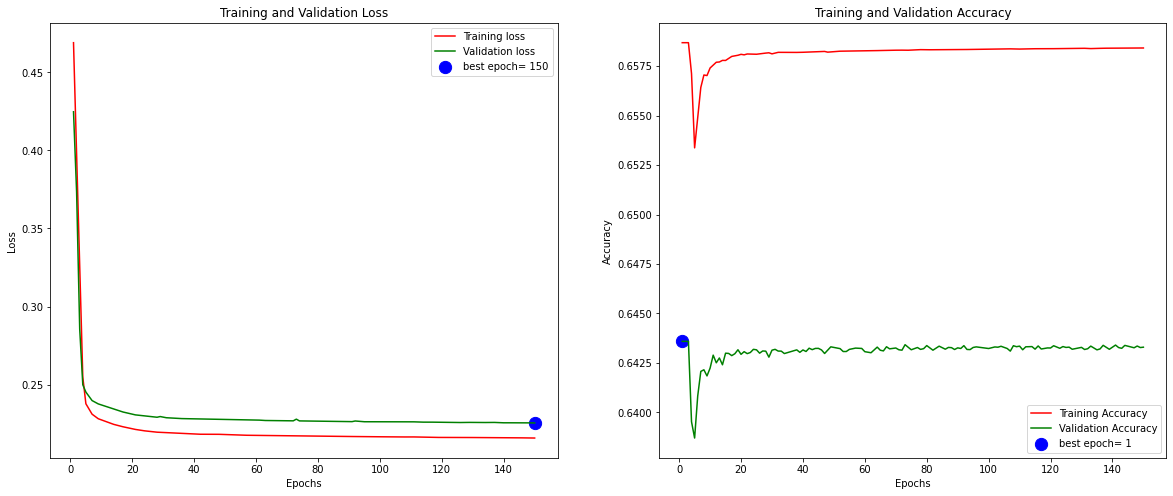

In [ ]:
tr_plot(history,0)

In [ ]:
autoencoder.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 228, 228, 3)]     0         
                                                                 
 conv2d_562 (Conv2D)         (None, 228, 228, 64)      1792      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 114, 114, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_563 (Conv2D)         (None, 114, 114, 32)      18464     
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 57, 57, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_564 (Conv2D)         (None, 57, 57, 16)        462

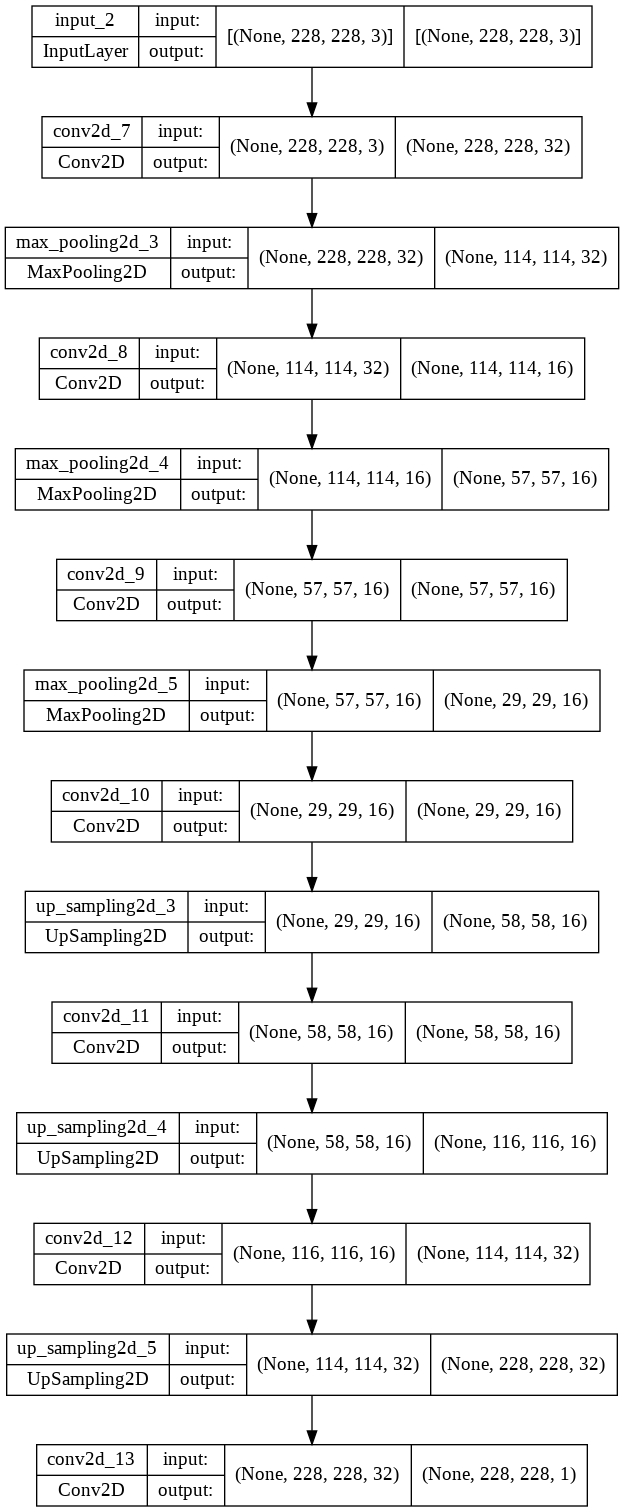

In [ ]:
plot_model(autoencoder, 'autoencoder.png', show_shapes=True)

In [ ]:
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=encoded)

plot_model(encoder, 'encoder_compress.png', show_shapes=True)
# save the encoder to file
encoder.save('encoder_{}.h5'.format(model_name))

In [ ]:
model_name = 'EfficientNetB3'
epoch = 150
preprocess = preEfficientNetB3
no_trainable_layers = 0

efficientNetB3 = EfficientNetB3(include_top = False, pooling= 'max',input_shape = (227,227,3), weights = 'imagenet')


for layer in efficientNetB3.layers[0:len(efficientNetB3.layers)-no_trainable_layers]:
    layer.trainable=False

'''
model_efficientNetB3 = keras.models.Sequential()

# Create new model on top
model_efficientNetB3.add(keras.Input(shape=(input_shape[0], input_shape[1], 3)))
model_efficientNetB3.add(efficientNetB3)
#model_efficientNetB3.add(keras.layers.GlobalAveragePooling2D())
#model_efficientNetB3.add(layers.Dense(units=512, activation='relu'))
#model_efficientNetB3.add(keras.layers.Dropout(0.2))  # Regularize with dropout
model_efficientNetB3.add(layers.Dense(units=512, activation='relu'))
model_efficientNetB3.add(layers.Dropout(0.3))
model_efficientNetB3.add(layers.Dense(units=5, activation='softmax'))

model_efficientNetB3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
'''

x= efficientNetB3.output
x= keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x= Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=layers.Dropout(rate=.45, seed=123)(x)        
output=Dense(5, activation='softmax')(x)
model_efficientNetB3=Model(inputs=efficientNetB3.input, outputs=output)
model_efficientNetB3.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) 


# simple early stopping
es = EarlyStopping(monitor='val_loss',min_delta=0, mode='auto', verbose=2, 
                    patience=10, baseline=None, restore_best_weights=True)

img_size = (227,227)

history = FitTransfer(encoder.predict(augment_train_val_data_AUTOENCODER(X_train, img_size, preprocess)), model_efficientNetB3, model_name , epoch)

best_acc = max(history.history['val_accuracy'])*100
print("-------------------")
print("Best accuracy achieved:", round(best_acc, 4), "%")


Found 320 validated image filenames.
Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/150
10/10 [==============================] - 19s 1s/step - loss: 9.9517 - accuracy: 0.2812 - val_loss: 11.1397 - val_accuracy: 0.3875
Epoch 2/150
10/10 [==============================] - 7s 716ms/step - loss: 9.2567 - accuracy: 0.4000 - val_loss: 10.1626 - val_accuracy: 0.5375
Epoch 3/150
10/10 [==============================] - 7s 710ms/step - loss: 8.6601 - accuracy: 0.5281 - val_loss: 9.4808 - val_accuracy: 0.5500
Epoch 4/150
10/10 [==============================] - 7s 705ms/step - loss: 8.4160 - accuracy: 0.5281 - val_loss: 8.8695 - val_accuracy: 0.6000
Epoch 5/150
10/10 [==============================] - 7s 723ms/step - loss: 8.1724 - accuracy: 0.5750 - val_loss: 8.4541 - val_accuracy: 0.6000
Epoch 6/150
10/10 [==============================] - 7s 705ms/step - loss: 7.9124 - accuracy: 0.5875 - val_loss: 8.1744 - val_acc

In [ ]:
model_efficientNetB3.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 227, 227, 3)  0           ['input_26[0][0]']               
                                                                                                  
 normalization (Normalization)  (None, 227, 227, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 229, 229, 3)  0           ['normalization[0][0]']   

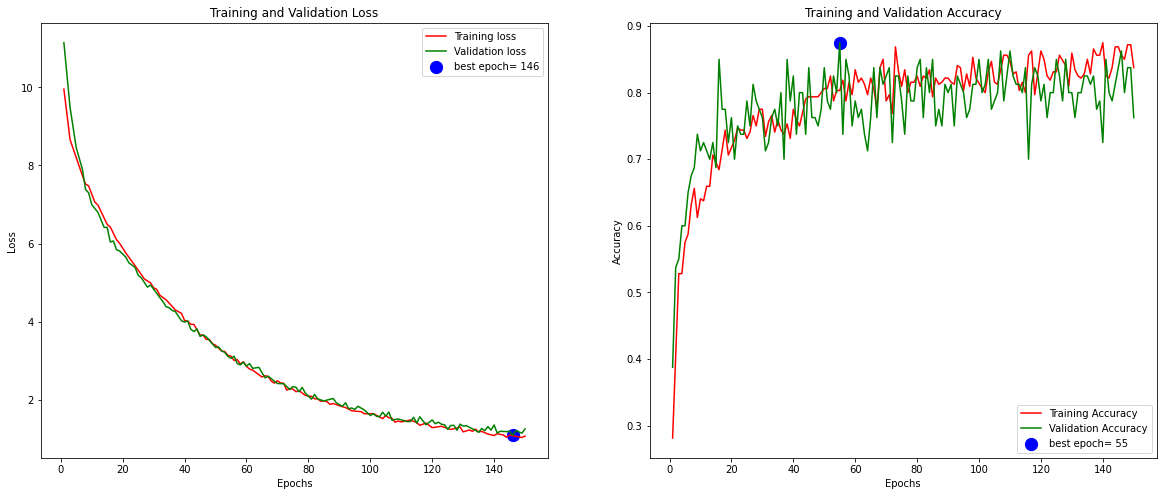

In [ ]:
tr_plot(history,0)

Found 100 validated image filenames belonging to 5 classes.
2/2 [==============================] - 3s 318ms/step
there were 15 errors in 100 tests for an accuracy of  85.00


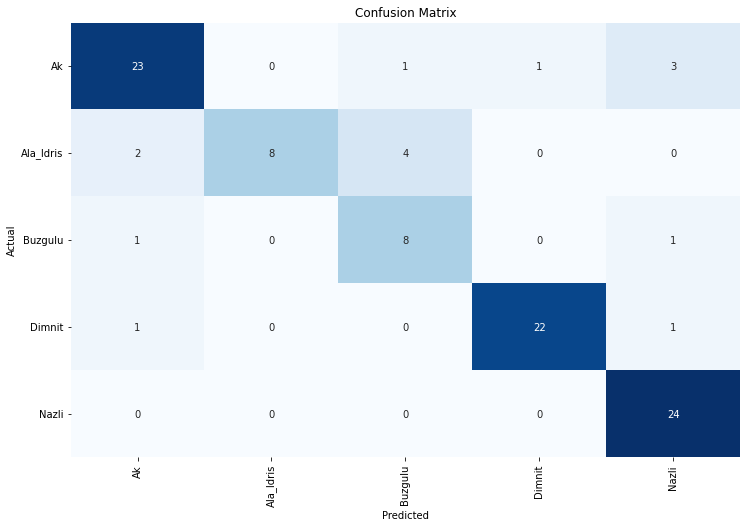

Classification Report:
----------------------
               precision    recall  f1-score   support

          Ak     0.8519    0.8214    0.8364        28
   Ala_Idris     1.0000    0.5714    0.7273        14
     Buzgulu     0.6154    0.8000    0.6957        10
      Dimnit     0.9565    0.9167    0.9362        24
       Nazli     0.8276    1.0000    0.9057        24

    accuracy                         0.8500       100
   macro avg     0.8503    0.8219    0.8202       100
weighted avg     0.8682    0.8500    0.8476       100



In [ ]:
errors, tests=predictor(test_val_generator(X_test, (227, 227), preprocess), test_steps, model_efficientNetB3)

In [ ]:
epoch = 150
#new_model= TrainTransfer(model_name, epoch=epoch, optimizer_algo='adam', activation='softmax')

model_inceptionV3 = keras.models.Sequential([
        inceptionV3,
        layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 ),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                     bias_regularizer=regularizers.l1(0.006) ,activation='relu'),
        layers.Dropout(rate=.45, seed=123),
        layers.Dense(5, activation='softmax')
    ])


model_inceptionV3.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) 

history = FitTransfer(encoder.predict(augment_train_val_data_AUTOENCODER(X_train, img_size, preprocess)), model_inceptionV3, model_name, epoch)

best_acc = max(history.history['val_accuracy'])*100
print("-------------------")
print("Best accuracy achieved:", round(best_acc, 4), "%")


Found 320 validated image filenames.
Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/150
10/10 [==============================] - 13s 871ms/step - loss: 5.1752 - accuracy: 0.2750 - val_loss: 5.1502 - val_accuracy: 0.2750
Epoch 2/150
10/10 [==============================] - 7s 765ms/step - loss: 4.8573 - accuracy: 0.3219 - val_loss: 4.7861 - val_accuracy: 0.3250
Epoch 3/150
10/10 [==============================] - 7s 705ms/step - loss: 4.5469 - accuracy: 0.4094 - val_loss: 4.4035 - val_accuracy: 0.5000
Epoch 4/150
10/10 [==============================] - 7s 704ms/step - loss: 4.3629 - accuracy: 0.4313 - val_loss: 4.1473 - val_accuracy: 0.5625
Epoch 5/150
10/10 [==============================] - 7s 707ms/step - loss: 4.2789 - accuracy: 0.4375 - val_loss: 4.0719 - val_accuracy: 0.4500
Epoch 6/150
10/10 [==============================] - 7s 710ms/step - loss: 4.2319 - accuracy: 0.4187 - val_loss: 3.9034 - val_ac

NameError: ignored

### **3.2. For denoising**

In [ ]:
# here we first corrupt the images by adding noise
# let's use the same autoencoder, with added gaussian noise!
#first let's train an autoencoder on our dataset, later we would use the decoder part for feature extraction

input_img = keras.Input(shape=(228, 228, 3))

noise = layers.GaussianNoise(0.1)(input_img)

visible = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(noise)
x = layers.MaxPooling2D((2, 2), padding='same')(visible)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [ ]:
denoising_autoencoder = keras.Model(input_img, decoded)
denoising_autoencoder.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [ ]:
img_size = (228, 228)

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=2, 
                    patience=10, restore_best_weights=True)

# fit the autoencoder model to reconstruct input
history = denoising_autoencoder.fit(augment_train_val_data_AUTOENCODER(X_train, img_size, preprocess),
                          epochs=200,
                          batch_size=128,
                          shuffle=True,
                          validation_data = augment_train_val_data_AUTOENCODER(X_val, img_size, preprocess),
                          callbacks=[es])

min_loss = min(history.history['val_loss'])*100
print("-------------------")
print("Minimum Loss Achieved:", round(min_loss, 4), "%")

Found 320 validated image filenames.
Found 80 validated image filenames.
Epoch 1/200
10/10 [==============================] - 4s 288ms/step - loss: 0.5461 - accuracy: 0.6543 - val_loss: 0.4528 - val_accuracy: 0.6393
Epoch 2/200
10/10 [==============================] - 3s 266ms/step - loss: 0.4391 - accuracy: 0.6565 - val_loss: 0.4417 - val_accuracy: 0.6436
Epoch 3/200
10/10 [==============================] - 3s 265ms/step - loss: 0.4120 - accuracy: 0.6587 - val_loss: 0.4151 - val_accuracy: 0.6436
Epoch 4/200
10/10 [==============================] - 3s 316ms/step - loss: 0.3860 - accuracy: 0.6587 - val_loss: 0.3804 - val_accuracy: 0.6436
Epoch 5/200
10/10 [==============================] - 3s 309ms/step - loss: 0.3391 - accuracy: 0.6587 - val_loss: 0.3261 - val_accuracy: 0.6436
Epoch 6/200
10/10 [==============================] - 3s 268ms/step - loss: 0.2831 - accuracy: 0.6585 - val_loss: 0.2788 - val_accuracy: 0.6431
Epoch 7/200
10/10 [==============================] - 3s 273ms/step - 

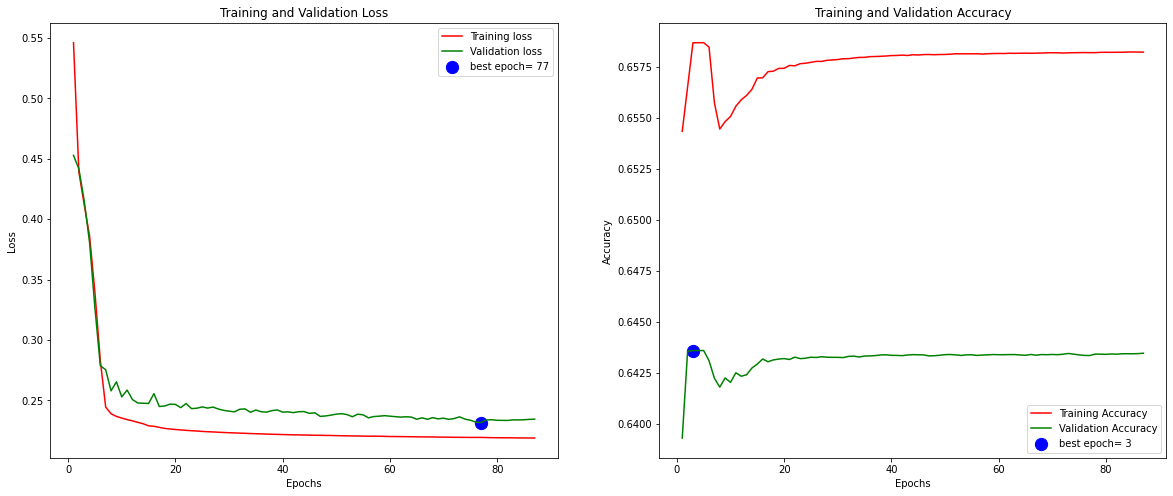

In [ ]:
tr_plot(history,0)

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 228, 228, 3)]     0         
                                                                 
 gaussian_noise_2 (GaussianN  (None, 228, 228, 3)      0         
 oise)                                                           
                                                                 
 conv2d_576 (Conv2D)         (None, 228, 228, 16)      448       
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 114, 114, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_577 (Conv2D)         (None, 114, 114, 16)      2320      
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 57, 57, 16)       0  

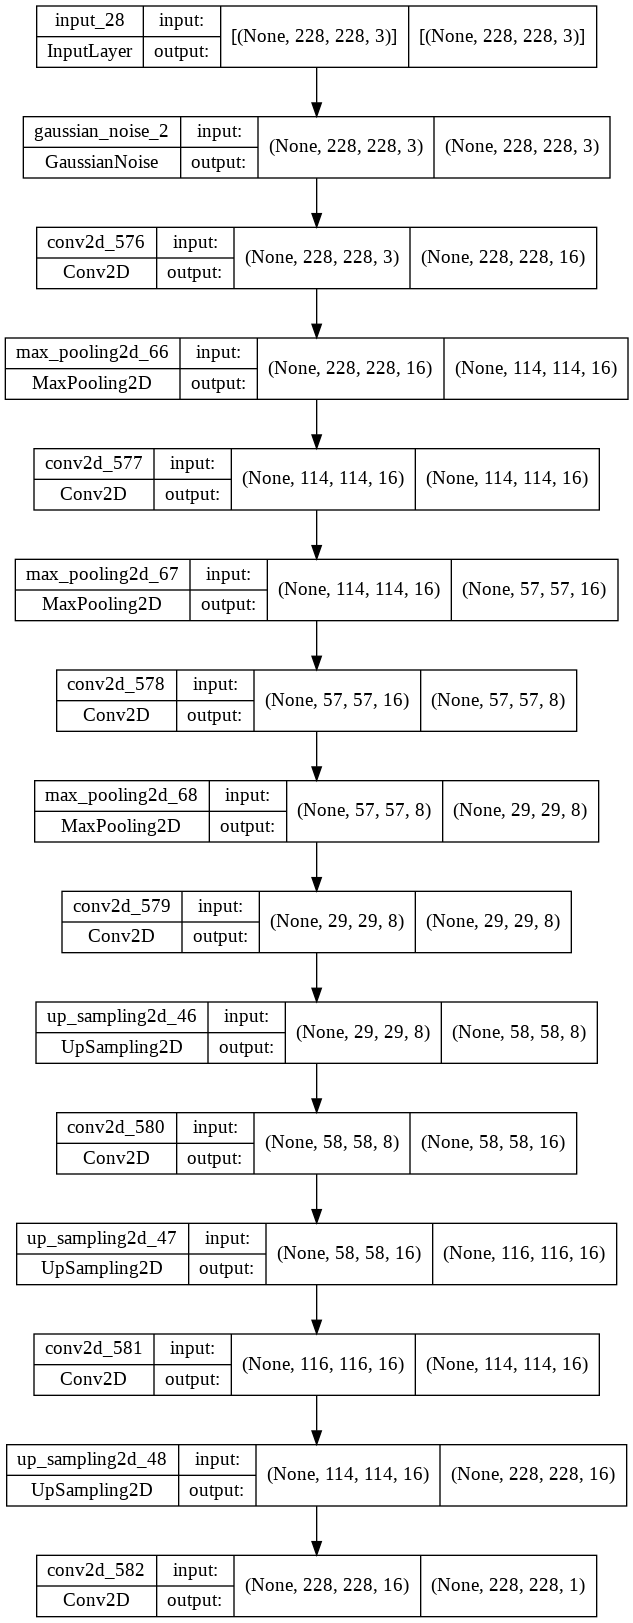

In [ ]:
denoising_autoencoder.summary()
plot_model(denoising_autoencoder, 'denoising_autoencoder.png', show_shapes=True)

In [ ]:
# define an denoising_encoder model (without the decoder)
denoising_encoder = keras.models.Sequential()
denoising_encoder.add(keras.Input(shape=(228, 228, 3)))
denoising_encoder.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model = Model(inputs=visible, outputs=encoded)
model.trainable=False
denoising_encoder.add(model)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

plot_model(denoising_encoder, 'encoder_compress.png', show_shapes=True)
# save the encoder to file
denoising_encoder.save('denoising_encoder.h5')

In [ ]:
model_name = 'EfficientNetB3'
epoch = 150
preprocess = preEfficientNetB3
no_trainable_layers = 15

efficientNetB3 = EfficientNetB3(include_top = False, pooling= 'max',input_shape = (227,227,3), weights = 'imagenet')


for layer in efficientNetB3.layers[0:len(efficientNetB3.layers)-no_trainable_layers]:
    layer.trainable=False

x= efficientNetB3.output
x= keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x= Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=layers.Dropout(rate=.45, seed=123)(x)        
output=Dense(5, activation='softmax')(x)
model_efficientNetB3=Model(inputs=efficientNetB3.input, outputs=output)
model_efficientNetB3.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) 


# simple early stopping
es = EarlyStopping(monitor='val_loss',min_delta=0, mode='auto', verbose=2, 
                    patience=10, baseline=None, restore_best_weights=True)

img_size = (227,227)

# simple early stopping
es = EarlyStopping(monitor='val_loss',min_delta=0, mode='auto', verbose=2, 
                    patience=10, baseline=None, restore_best_weights=True)

img_size = (227,227)

history = FitTransfer(denoising_encoder.predict(augment_train_val_data_AUTOENCODER(X_train, img_size, preprocess)), model_efficientNetB3, model_name , epoch)

best_acc = max(history.history['val_accuracy'])*100
print("-------------------")
print("Best accuracy achieved:", round(best_acc, 4), "%")

Found 320 validated image filenames.
Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/150
10/10 [==============================] - 53s 5s/step - loss: 9.6559 - accuracy: 0.3969 - val_loss: 10.5604 - val_accuracy: 0.4625
Epoch 2/150
10/10 [==============================] - 7s 709ms/step - loss: 8.9189 - accuracy: 0.5250 - val_loss: 11.6662 - val_accuracy: 0.3500
Epoch 3/150
10/10 [==============================] - 7s 720ms/step - loss: 8.6468 - accuracy: 0.5531 - val_loss: 9.9965 - val_accuracy: 0.5250
Epoch 4/150
10/10 [==============================] - 7s 722ms/step - loss: 8.3921 - accuracy: 0.6438 - val_loss: 9.0390 - val_accuracy: 0.6000
Epoch 5/150
10/10 [==============================] - 10s 1s/step - loss: 7.9735 - accuracy: 0.6625 - val_loss: 8.6931 - val_accuracy: 0.6375
Epoch 6/150
10/10 [==============================] - 8s 719ms/step - loss: 7.7988 - accuracy: 0.6625 - val_loss: 8.3244 - val_accur

Found 100 validated image filenames belonging to 5 classes.
2/2 [==============================] - 1s 304ms/step
there were 16 errors in 100 tests for an accuracy of  84.00


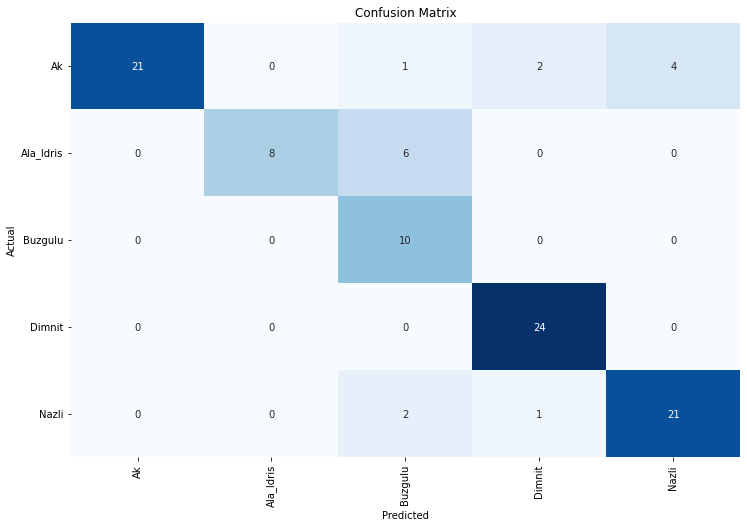

Classification Report:
----------------------
               precision    recall  f1-score   support

          Ak     1.0000    0.7500    0.8571        28
   Ala_Idris     1.0000    0.5714    0.7273        14
     Buzgulu     0.5263    1.0000    0.6897        10
      Dimnit     0.8889    1.0000    0.9412        24
       Nazli     0.8400    0.8750    0.8571        24

    accuracy                         0.8400       100
   macro avg     0.8510    0.8393    0.8145       100
weighted avg     0.8876    0.8400    0.8424       100



In [ ]:
errors, tests=predictor(test_val_generator(X_test, (227, 227), preprocess), test_steps, model_efficientNetB3)

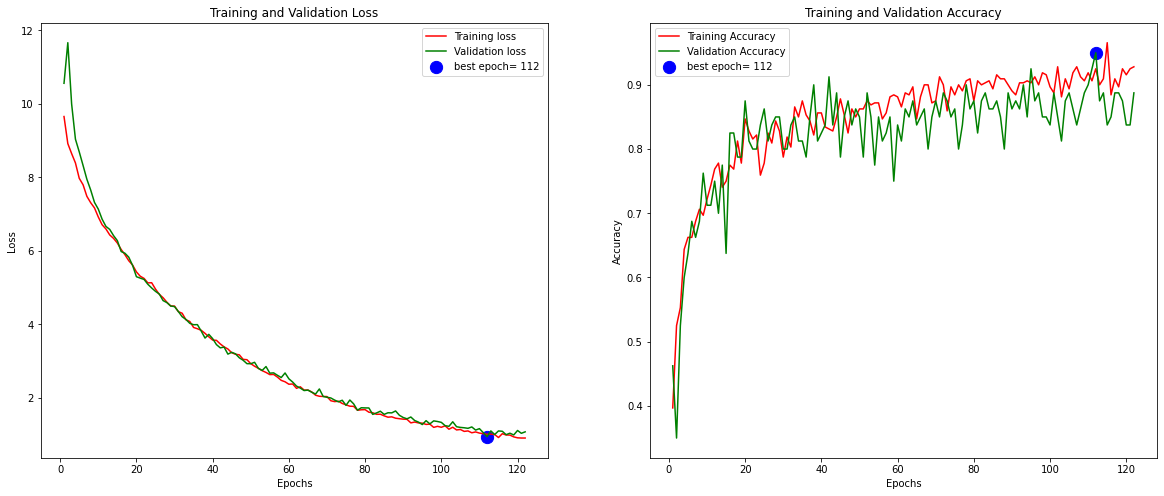

In [ ]:
tr_plot(history,0)

## **4. 10-Fold Cross Validation**

Stratified is to ensure that each fold of dataset has the same proportion of observations with a given label.

So, it means that StratifiedKFold is the improved version of KFold

Therefore, the answer to this question is we should prefer StratifiedKFold over KFold when dealing with classification tasks with imbalanced class distributions.

In [ ]:
def get_model_name(k):
  return 'model_'+str(k)+'.h5'
def gen_validation(X_val, preProcessFunc):
  test_validation_generator=ImageDataGenerator(preprocessing_function=preProcessFunc)

  length_val=len(X_val)
  val_batch_size=sorted([int(length_val/n) for n in range(1,length_val+1) if length_val % n ==0 and length_val/n<=80],reverse=True)[0]  
  val_steps=int(length_val/val_batch_size)
  val_gen=test_validation_generator.flow_from_dataframe(X_val, x_col='path', y_col='label', target_size=img_size,
                                    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
  return val_gen

In [ ]:

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

X_merged = pd.concat([X_train, X_val])
y_merged = pd.concat([y_train, y_val])

Y = y_merged[['label']]
n=len(Y)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

validation_accuracy = []
validation_loss = []

save_dir = '/saved_models/'
fold_var = 1

model_name = 'InceptionV3'
epoch = 20
preprocess = preInceptionV3
no_trainable_layers = 15


for train_index, val_index in skf.split(np.zeros(n),Y):

  training_data   = X_merged.iloc[train_index]
  validation_data = X_merged.iloc[val_index]

  # CREATE and COMPILE NEW MODEL

  inceptionV3 = InceptionV3(include_top = False, pooling= 'max',input_shape = (227,227,3), weights = 'imagenet')

  for layer in inceptionV3.layers[0:len(inceptionV3.layers)-no_trainable_layers]:
      layer.trainable=False
    
  model = keras.models.Sequential([
          inceptionV3,
          layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 ),
          layers.Flatten(),
          layers.Dropout(0.2),
          layers.Dense(128, activation="relu"),
          layers.Dropout(0.3),
          layers.Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                      bias_regularizer=regularizers.l1(0.006) ,activation='relu'),
          layers.Dropout(rate=.45, seed=123),
          layers.Dense(5, activation='softmax')
      ])

  model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) 

  # CREATE CALLBACKS
  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
                                                  monitor='val_accuracy', verbose=1, 
                                                  save_best_only=True, mode='max')
  # simple early stopping
  es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, 
                    patience=10)

  callbacks_list = [checkpoint, es]


  input_shape = (224,224)
  # There can be other callbacks, but just showing one because it involves the model name
  # This saves the best model
  # FIT THE MODEL
  history = model.fit(augment_train_val_data(training_data, input_shape, preprocess),
                      validation_data=augment_train_val_data(validation_data, input_shape, preprocess),
                      epochs=epoch, 
                      verbose=0, 
                      callbacks=callbacks_list)
  
  #PLOT HISTORY
  #tr_plot(history,0)
  
  # LOAD BEST MODEL to evaluate the performance of the model
  model.load_weights("/saved_models/model_"+str(fold_var)+".h5")
  
  results = model.evaluate(augment_train_val_data(validation_data, input_shape, preprocess))
  results = dict(zip(model.metrics_names,results))
  
  validation_accuracy.append(results['accuracy'])
  validation_loss.append(results['loss'])
  
  tf.keras.backend.clear_session()
  
  fold_var += 1

Found 360 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.

Epoch 1: val_accuracy improved from -inf to 0.27500, saving model to /saved_models/model_1.h5

Epoch 2: val_accuracy did not improve from 0.27500

Epoch 3: val_accuracy improved from 0.27500 to 0.37500, saving model to /saved_models/model_1.h5

Epoch 4: val_accuracy improved from 0.37500 to 0.42500, saving model to /saved_models/model_1.h5

Epoch 5: val_accuracy did not improve from 0.42500

Epoch 6: val_accuracy improved from 0.42500 to 0.57500, saving model to /saved_models/model_1.h5

Epoch 7: val_accuracy did not improve from 0.57500

Epoch 8: val_accuracy did not improve from 0.57500

Epoch 9: val_accuracy did not improve from 0.57500

Epoch 10: val_accuracy did not improve from 0.57500

Epoch 11: val_accuracy did not improve from 0.57500

Epoch 12: val_accuracy did not improve from 0.57500

Epoch 13: val_accuracy improved from 0.57500 to 0.62500, saving model to

In [ ]:
model, validation_accuracy, validation_loss

(KerasClassifier(
 	model=<function create_model at 0x7f03a01023b0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=SGD
 	loss=categorical_crossentropy
 	metrics=None
 	batch_size=32
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=100
 	class_weight=None
 ),
 [0.625,
  0.675000011920929,
  0.6499999761581421,
  0.675000011920929,
  0.699999988079071,
  0.574999988079071,
  0.7250000238418579,
  0.800000011920929,
  0.6499999761581421,
  0.6000000238418579],
 [3.1492562294006348,
  3.0734548568725586,
  3.1441166400909424,
  3.231564998626709,
  3.0696144104003906,
  3.1267590522766113,
  3.1379451751708984,
  3.0266435146331787,
  3.026719093322754,
  3.9497344493865967])

In [ ]:
validation_accuracy.append(np.mean(validation_accuracy))

In [ ]:
validation_accuracy = [round(val*100, 4) for val in validation_accuracy]

In [ ]:
validation_accuracy

[62.5, 67.5, 65.0, 67.5, 70.0, 57.5, 72.5, 80.0, 65.0, 60.0, 66.75]

In [ ]:
array_val = np.array([validation_accuracy])
  
# creating a list of index names
column_values = ['1st Fold', '2nd Fold', '3rd Fold', '4th Fold', '5th Fold', '6th Fold', '7th Fold', '8th Fold', '9th Fold', '10th Fold', 'Average']
   
# creating a list of column names
index_values= [model_name]
  
# creating the dataframe
df = pd.DataFrame(data = array_val, 
                  index = index_values, 
                  columns = column_values)

In [ ]:
df

,1st Fold,2nd Fold,3rd Fold,4th Fold,5th Fold,6th Fold,7th Fold,8th Fold,9th Fold,10th Fold,Average
InceptionV3,62.5,67.5,65.0,67.5,70.0,57.5,72.5,80.0,65.0,60.0,66.75


In [ ]:
print("Validation Accuracy:")
print("%.2f%% (+/- %.2f%%)" % (np.mean(validation_accuracy), np.std(validation_accuracy)))
print("Validation Loss:")
print("%.2f%% (+/- %.2f%%)" % (np.mean(validation_loss), np.std(validation_loss)))

Validation Accuracy:
66.75% (+/- 5.84%)
Validation Loss:
3.19% (+/- 0.26%)


In [ ]:
best_model_acc = max(validation_accuracy)
best_model_no = validation_accuracy.index(best_model_acc)+1
print("Best model number is", best_model_no, "with validation accuracy of", round(best_model_acc), "%." )

Best model number is 8 with validation accuracy of 80 %.


Found 100 validated image filenames belonging to 5 classes.
2/2 [==============================] - 2s 312ms/step
there were 27 errors in 100 tests for an accuracy of  73.00


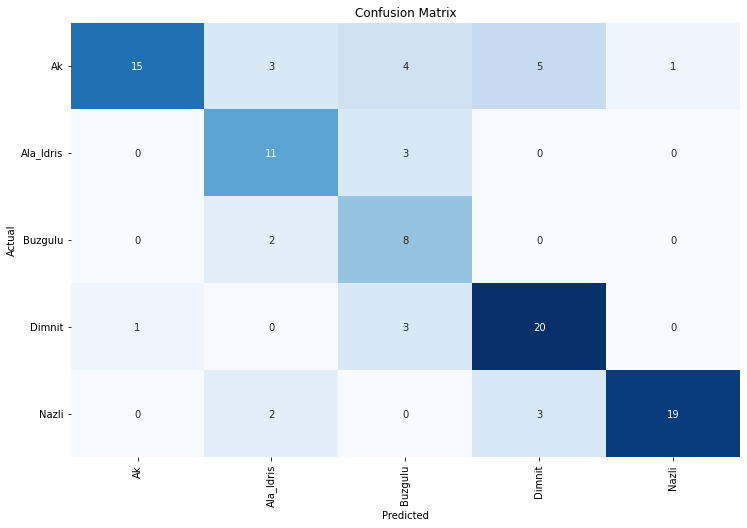

Classification Report:
----------------------
               precision    recall  f1-score   support

          Ak     0.9375    0.5357    0.6818        28
   Ala_Idris     0.6111    0.7857    0.6875        14
     Buzgulu     0.4444    0.8000    0.5714        10
      Dimnit     0.7143    0.8333    0.7692        24
       Nazli     0.9500    0.7917    0.8636        24

    accuracy                         0.7300       100
   macro avg     0.7315    0.7493    0.7147       100
weighted avg     0.7919    0.7300    0.7362       100



In [ ]:
# LOAD BEST MODEL to predict 
inceptionV3 = InceptionV3(include_top = False, pooling= 'max',input_shape = (227,227,3), weights = 'imagenet')

for layer in inceptionV3.layers[0:len(inceptionV3.layers)-no_trainable_layers]:
    layer.trainable=False
  
model = keras.models.Sequential([
        inceptionV3,
        layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 ),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu'),
        layers.Dropout(rate=.45, seed=123),
        layers.Dense(5, activation='softmax')
    ])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) 

model.load_weights("/saved_models/model_"+str(8)+".h5")
errors, tests=predictor(test_val_generator(X_test, (227, 227), preprocess), test_steps, model)

## **5. Improving The Accuracy (Extra Credit)**


Unfreezing All the Pre-trained Layers


In [ ]:
img_shape=(227, 227, 3)
model_name='EfficientNetB3'
preprocess = preEfficientNetB3
epoch = 40
efficientNetB3= EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
# let's make our base model fully trainable to see what happens
efficientNetB3.trainable=True
x=efficientNetB3.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x=Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=efficientNetB3.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

# simple early stopping
es = EarlyStopping(monitor='val_loss',min_delta=0, mode='auto', verbose=2, 
                    patience=30, baseline=None, restore_best_weights=True)

input_shape = (227,227)
history = model.fit(
      augment_train_val_data(X_train, input_shape, preprocess),
      validation_data=augment_train_val_data(X_val, input_shape, preprocess),
      epochs=epoch,
      verbose=2,
      callbacks=[es],
      validation_steps=None,  
      shuffle=False,  
      initial_epoch=0)

best_acc = max(history.history['val_accuracy'])*100
print("-------------------")
print("Best accuracy achieved:", round(best_acc, 4), "%")

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/40
10/10 - 29s - loss: 9.5654 - accuracy: 0.3688 - val_loss: 15.8849 - val_accuracy: 0.2625 - 29s/epoch - 3s/step
Epoch 2/40
10/10 - 9s - loss: 8.9368 - accuracy: 0.5125 - val_loss: 14.1922 - val_accuracy: 0.2875 - 9s/epoch - 943ms/step
Epoch 3/40
10/10 - 9s - loss: 8.3626 - accuracy: 0.6469 - val_loss: 14.3517 - val_accuracy: 0.2500 - 9s/epoch - 934ms/step
Epoch 4/40
10/10 - 9s - loss: 7.9053 - accuracy: 0.7250 - val_loss: 11.1345 - val_accuracy: 0.3000 - 9s/epoch - 946ms/step
Epoch 5/40
10/10 - 9s - loss: 7.5016 - accuracy: 0.8344 - val_loss: 11.0979 - val_accuracy: 0.3375 - 9s/epoch - 937ms/step
Epoch 6/40
10/10 - 10s - loss: 7.3614 - accuracy: 0.8000 - val_loss: 10.3050 - val_accuracy: 0.3375 - 10s/epoch - 1s/step
Epoch 7/40
10/10 - 10s - loss: 7.1320 - accuracy: 0.8406 - val_loss: 9.0550 - val_accuracy: 0.3375 - 10s/epoch - 957ms/step
Epoch 8/40
10/10 - 9s

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 227, 227, 3)  0           ['input_8[0][0]']                
                                                                                                  
 normalization_5 (Normalization  (None, 227, 227, 3)  7          ['rescaling_5[0][0]']            
 )                                                                                                
                                                                                            

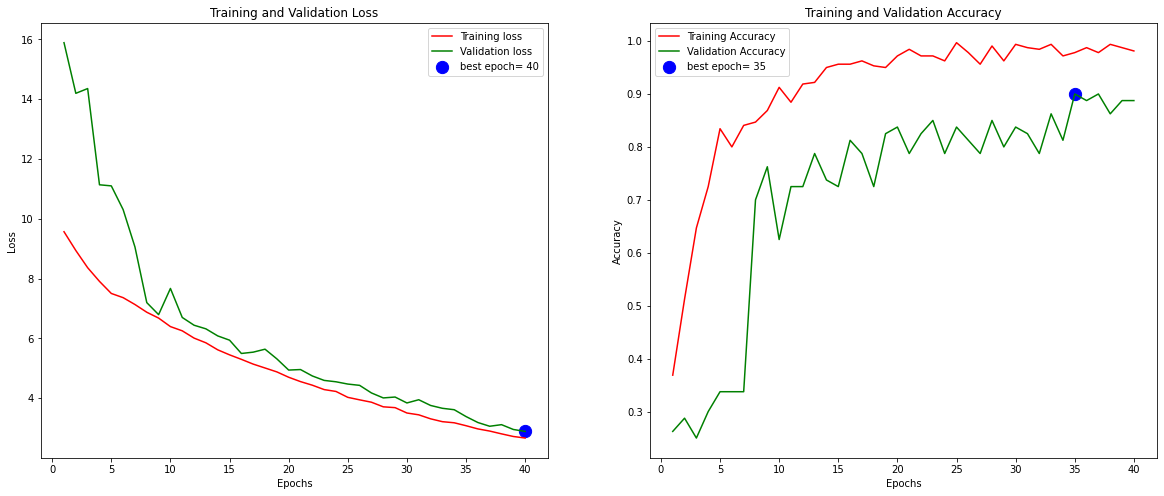

In [ ]:
tr_plot(history,0)

Found 100 validated image filenames belonging to 5 classes.
2/2 [==============================] - 3s 309ms/step
there were 3 errors in 100 tests for an accuracy of  97.00


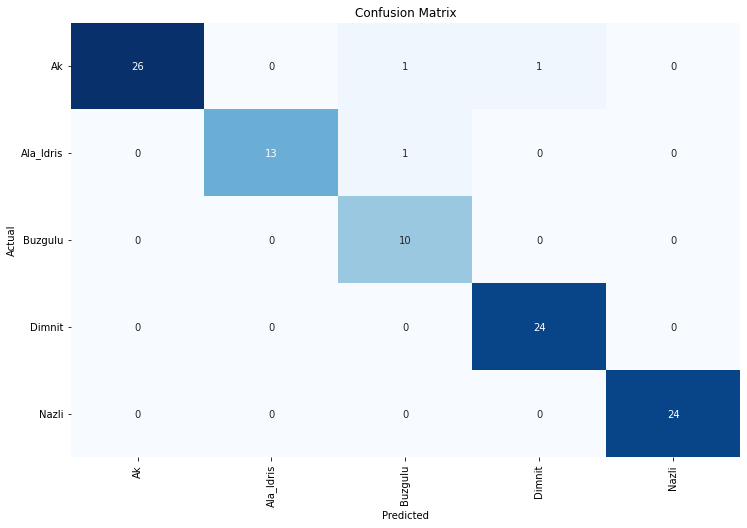

Classification Report:
----------------------
               precision    recall  f1-score   support

          Ak     1.0000    0.9286    0.9630        28
   Ala_Idris     1.0000    0.9286    0.9630        14
     Buzgulu     0.8333    1.0000    0.9091        10
      Dimnit     0.9600    1.0000    0.9796        24
       Nazli     1.0000    1.0000    1.0000        24

    accuracy                         0.9700       100
   macro avg     0.9587    0.9714    0.9629       100
weighted avg     0.9737    0.9700    0.9705       100



In [ ]:
errors, tests=predictor(test_val_generator(X_test, (227, 227), preprocess), test_steps, model)

10 fold cross validation again

In [ ]:

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

X_merged = pd.concat([X_train, X_val])
y_merged = pd.concat([y_train, y_val])

Y = y_merged[['label']]
n=len(Y)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

validation_accuracy = []
validation_loss = []

save_dir = '/saved_models/'
fold_var = 1

img_shape=(227, 227, 3)
model_name='EfficientNetB3'
preprocess = preEfficientNetB3
epoch = 40
input_shape = (227,227)

for train_index, val_index in skf.split(np.zeros(n),Y):
  training_data   = X_merged.iloc[train_index]
  validation_data = X_merged.iloc[val_index]

  # CREATE and COMPILE NEW MODEL

  efficientNetB3= EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 

  # let's make our base model fully trainable to see what happens
  efficientNetB3.trainable=True
  x=efficientNetB3.output
  x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
  x=Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                  bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
  x=Dropout(rate=.4, seed=123)(x)       
  output=Dense(class_count, activation='softmax')(x)
  model=Model(inputs=efficientNetB3.input, outputs=output)
  lr=.001 # start with this learning rate
  model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

  # CREATE CALLBACKS
  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
                                                  monitor='val_accuracy', verbose=1, 
                                                  save_best_only=True, mode='max')
  # simple early stopping
  es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, 
                    patience=10)

  callbacks_list = [checkpoint, es]


  input_shape = (224,224)
  # There can be other callbacks, but just showing one because it involves the model name
  # This saves the best model
  # FIT THE MODEL
  history = model.fit(augment_train_val_data(training_data, input_shape, preprocess),
                      validation_data=augment_train_val_data(validation_data, input_shape, preprocess),
                      epochs=epoch, 
                      verbose=0, 
                      callbacks=callbacks_list,
                      validation_steps=None,  
                      shuffle=False,  
                      initial_epoch=0)
  
  #PLOT HISTORY
  #tr_plot(history,0)
  
  # LOAD BEST MODEL to evaluate the performance of the model
  model.load_weights("/saved_models/model_"+str(fold_var)+".h5")
  
  results = model.evaluate(augment_train_val_data(validation_data, input_shape, preprocess))
  results = dict(zip(model.metrics_names,results))
  
  validation_accuracy.append(results['accuracy'])
  validation_loss.append(results['loss'])
  
  tf.keras.backend.clear_session()
  
  fold_var += 1

Found 360 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.

Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to /saved_models/model_1.h5

Epoch 2: val_accuracy improved from 0.25000 to 0.32500, saving model to /saved_models/model_1.h5

Epoch 3: val_accuracy improved from 0.32500 to 0.37500, saving model to /saved_models/model_1.h5

Epoch 4: val_accuracy improved from 0.37500 to 0.50000, saving model to /saved_models/model_1.h5

Epoch 5: val_accuracy improved from 0.50000 to 0.55000, saving model to /saved_models/model_1.h5

Epoch 6: val_accuracy improved from 0.55000 to 0.65000, saving model to /saved_models/model_1.h5

Epoch 7: val_accuracy did not improve from 0.65000

Epoch 8: val_accuracy did not improve from 0.65000

Epoch 9: val_accuracy improved from 0.65000 to 0.77500, saving model to /saved_models/model_1.h5

Epoch 10: val_accuracy did not improve from 0.77500

Epoch 11: val_accuracy did not improve f

In [ ]:
model, validation_accuracy, validation_loss

(<keras.engine.functional.Functional at 0x7f039a01ecd0>,
 [0.800000011920929,
  0.574999988079071,
  0.75,
  0.8999999761581421,
  0.800000011920929,
  0.7749999761581421,
  0.875,
  0.8999999761581421,
  0.875,
  0.7250000238418579],
 [7.197813987731934,
  8.638017654418945,
  6.665896415710449,
  6.041355133056641,
  5.483118057250977,
  6.231280326843262,
  4.933213233947754,
  4.972812175750732,
  6.316766262054443,
  5.974222183227539])

In [ ]:
validation_accuracy.append(np.mean(validation_accuracy))

In [ ]:
validation_accuracy = [round(val*100, 4) for val in validation_accuracy]

In [ ]:
validation_accuracy

[80.0, 57.5, 75.0, 90.0, 80.0, 77.5, 87.5, 90.0, 87.5, 72.5, 79.75]

In [ ]:
array_val = np.array([validation_accuracy])
  
# creating a list of index names
column_values = ['1st Fold', '2nd Fold', '3rd Fold', '4th Fold', '5th Fold', '6th Fold', '7th Fold', '8th Fold', '9th Fold', '10th Fold', 'Average']
   
# creating a list of column names
index_values= [model_name]
  
# creating the dataframe
df = pd.DataFrame(data = array_val, 
                  index = index_values, 
                  columns = column_values)

In [ ]:
df

,1st Fold,2nd Fold,3rd Fold,4th Fold,5th Fold,6th Fold,7th Fold,8th Fold,9th Fold,10th Fold,Average
EfficientNetB3,80.0,57.5,75.0,90.0,80.0,77.5,87.5,90.0,87.5,72.5,79.75


In [ ]:
print("Validation Accuracy:")
print("%.2f%% (+/- %.2f%%)" % (np.mean(validation_accuracy), np.std(validation_accuracy)))
print("Validation Loss:")
print("%.2f%% (+/- %.2f%%)" % (np.mean(validation_loss), np.std(validation_loss)))

Validation Accuracy:
79.75% (+/- 9.07%)
Validation Loss:
6.25% (+/- 1.04%)


In [ ]:
best_model_acc = max(validation_accuracy)
best_model_no = validation_accuracy.index(best_model_acc)+1
print("Best model number is", best_model_no, "with validation accuracy of", round(best_model_acc), "%." )

Best model number is 4 with validation accuracy of 90 %.


Found 100 validated image filenames belonging to 5 classes.
2/2 [==============================] - 3s 313ms/step
there were 12 errors in 100 tests for an accuracy of  88.00


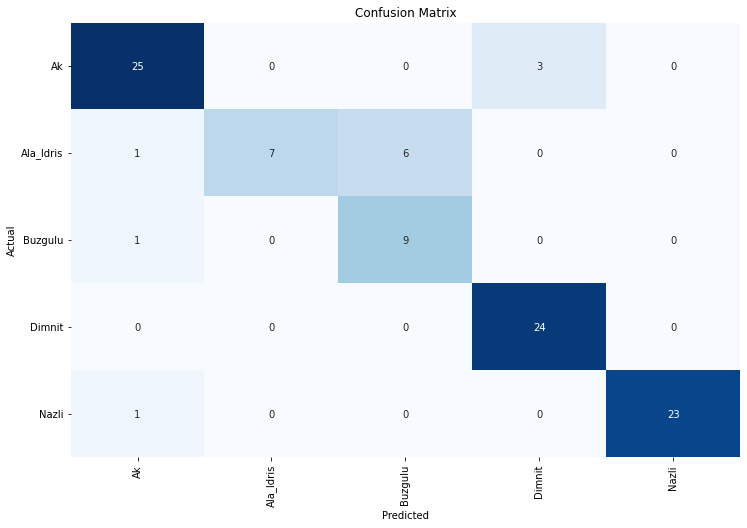

Classification Report:
----------------------
               precision    recall  f1-score   support

          Ak     0.8929    0.8929    0.8929        28
   Ala_Idris     1.0000    0.5000    0.6667        14
     Buzgulu     0.6000    0.9000    0.7200        10
      Dimnit     0.8889    1.0000    0.9412        24
       Nazli     1.0000    0.9583    0.9787        24

    accuracy                         0.8800       100
   macro avg     0.8763    0.8502    0.8399       100
weighted avg     0.9033    0.8800    0.8761       100



In [ ]:
# CREATE and COMPILE NEW MODEL

efficientNetB3= EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 

# let's make our base model fully trainable to see what happens
efficientNetB3.trainable=True
x=efficientNetB3.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x=Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=efficientNetB3.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

# LOAD BEST MODEL to predict 
model.load_weights("/saved_models/model_"+str(4)+".h5")
errors, tests=predictor(test_val_generator(X_test, (227, 227), preprocess), test_steps, model)

In [ ]:
model_comparison = {'Model_Name': ['MobileNetV2', 'ResNet50', 'EfficientNetB3', 'InceptionV3', 'Fully Trainable EfficientNetB3'],
                    'Num_Trainable_Params': [921093, 2369029, 2099717, 695173, 11094061],
                    'Validation_Accuracy': [90, 81, 96, 91, 90],
                    'Test_Accuracy':[80, 75, 89, 88, 97]}

# Convert Results to DataFrame for easy viewing
model_comparison_df = pd.DataFrame(model_comparison)
model_comparison_df.sort_values('Test_Accuracy', inplace=True, ascending=False) # sort in ascending order of num_model_params column
model_comparison_df

,Model_Name,Num_Trainable_Params,Validation_Accuracy,Test_Accuracy
4,Fully Trainable EfficientNetB3,11094061,90,97
2,EfficientNetB3,2099717,96,89
3,InceptionV3,695173,91,88
0,MobileNetV2,921093,90,80
1,ResNet50,2369029,81,75


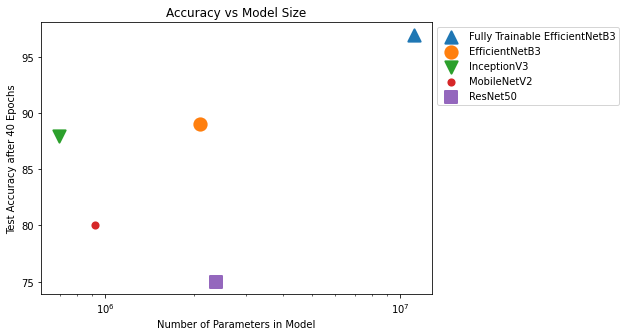

In [ ]:
# Loop over each row and plot the num_model_params vs validation_accuracy
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]
plt.figure(figsize=(7,5))
for row in model_comparison_df.itertuples():
    plt.scatter(row.Num_Trainable_Params, row.Test_Accuracy, label=row.Model_Name, marker=markers[row.Index], s=150, linewidths=2)
plt.xscale('log')
plt.xlabel('Number of Parameters in Model')
plt.ylabel('Test Accuracy after {} Epochs'.format(epoch))
plt.title('Accuracy vs Model Size')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left'); # Move legend out of the plot

---